In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
from torchvision import transforms
import cv2
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing
from tqdm import tqdm
import rosbag

import os

from FRM import AutoEncoder
from feature_dataset import CustomFeatureSensorSceneDataset
from Swin3d import Swin3D_fine_tune

/opt/ros/noetic/lib/python3/dist-packages/rosbag/bag.py:1568: SyntaxWarning: invalid escape sequence '\d'
  matches = re.match("#ROS(.*) V(\d).(\d)", version_line)


In [2]:
model = Swin3D_fine_tune(n_classes=7)

model = torch.load('weights/Swin3d_action_recognition.pt',weights_only=False)

model.classifier = nn.Identity()

In [3]:
def video_to_16_frame_clips(action_folder_path, output_folder, clip_length=16):
    os.makedirs(output_folder, exist_ok=True)

    files = os.listdir(action_folder_path)

    for video in files:
        if video.endswith('.mp4'):
            video_path = os.path.join(action_folder_path, video)
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

            video_output_folder = os.path.join(output_folder, os.path.splitext(video)[0])
            os.makedirs(video_output_folder, exist_ok=True)

            max_clips = total_frames // clip_length
            interval = total_frames // clip_length

            for clip_count in range(max_clips):
                frames = []

                for i in range(clip_length):
                    frame_index = clip_count + i * max_clips
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                    ret, frame = cap.read()
                    if ret:
                        frames.append(frame)

                clip_path = os.path.join(video_output_folder, f'clip_{clip_count:04d}.mp4')
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                out = cv2.VideoWriter(clip_path, fourcc, fps, (width, height))

                for frame in frames:
                    out.write(frame)

                out.release()

            cap.release()

def video_to_16_frame_sequential_clips(action_folder_path, output_folder, clip_length=16):
    os.makedirs(output_folder, exist_ok=True)

    files = os.listdir(action_folder_path)

    for video in files:
        if video.endswith('.mp4'):
            video_path = os.path.join(action_folder_path, video)
            cap = cv2.VideoCapture(video_path)
            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

            video_output_folder = os.path.join(output_folder, os.path.splitext(video)[0])
            os.makedirs(video_output_folder, exist_ok=True)

            max_clips = total_frames // clip_length

            for clip_count in range(max_clips):
                frames = []

                for i in range(clip_length):
                    frame_index = clip_count * clip_length + i
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                    ret, frame = cap.read()
                    if ret:
                        frames.append(frame)

                clip_path = os.path.join(video_output_folder, f'clip_{clip_count:04d}.mp4')
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                out = cv2.VideoWriter(clip_path, fourcc, fps, (width, height))

                for frame in frames:
                    out.write(frame)

                out.release()

            cap.release()

def video_to_16_frame_sequential_clips_no_action(action_folder_path, output_folder, clip_length=16):

    os.makedirs(output_folder, exist_ok=True)

    # List all video files in the input folder
    for video in os.listdir(action_folder_path):
        if video.endswith('.MP4'):
            video_path = os.path.join(action_folder_path, video)
            cap = cv2.VideoCapture(video_path)

            total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            fps = cap.get(cv2.CAP_PROP_FPS)
            width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

            # Output subfolder for the current video
            video_output_folder = os.path.join(output_folder, os.path.splitext(video)[0])
            os.makedirs(video_output_folder, exist_ok=True)

            max_clips = total_frames // clip_length

            # Create sequential clips
            for clip_count in range(max_clips):
                frames = []
                for i in range(clip_length):
                    frame_index = clip_count * clip_length + i
                    cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
                    ret, frame = cap.read()
                    if ret:
                        frames.append(frame)

                clip_path = os.path.join(video_output_folder, f'clip_{clip_count:04d}.mp4')
                fourcc = cv2.VideoWriter_fourcc(*'mp4v')
                out = cv2.VideoWriter(clip_path, fourcc, fps, (width, height))

                for frame in frames:
                    out.write(frame)
                out.release()

            cap.release()

def mask_random_parts(image, num_masks=5, mask_size_range=(100, 200)):
    masked_image = image.copy()
    height, width, _ = image.shape

    for _ in range(num_masks):
        mask_width = np.random.randint(mask_size_range[0], mask_size_range[1])
        mask_height = np.random.randint(mask_size_range[0], mask_size_range[1])

        x = np.random.randint(0, width - mask_width)
        y = np.random.randint(0, height - mask_height)

        masked_image[y:y+mask_height, x:x+mask_width] = [0, 0, 0]

    return masked_image

def apply_mask_to_video(input_path, output_path, num_masks=5, mask_size_range=(50, 100)):
    # Open the video file
    cap = cv2.VideoCapture(input_path)

    if not cap.isOpened():
        print("Error: Could not open video.")
        return

    # Get video properties
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Define the codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

    # Process each frame
    for _ in range(frame_count):
        ret, frame = cap.read()
        if not ret:
            break

        # Apply mask to the frame
        masked_frame = mask_random_parts(frame, num_masks, mask_size_range)

        # Write the frame to the output video
        out.write(masked_frame)

    # Release the video capture and writer objects
    cap.release()
    out.release()


In [4]:
def get_pred(vector):
    probabilities = F.softmax(vector, dim=0)

    predicted_class_index = torch.argmax(probabilities).item()
    csv_file_path = 'kinetics_400_labels.csv'

    df = pd.read_csv(csv_file_path)
    df = df.drop(columns=['id'])

    print(df.loc[predicted_class_index]['name'])

def get_pred_top_5(vector, csv_file_path='kinetics_400_labels.csv', top_k=5):
    probabilities = F.softmax(vector, dim=0)

    top_k_probabilities, top_k_indices = torch.topk(probabilities, top_k)

    df = pd.read_csv(csv_file_path)
    df = df.drop(columns=['id'])

    top_k_classes = df.loc[top_k_indices.cpu().numpy(), 'name'].tolist()

    top_k_results = list(zip(top_k_classes, top_k_probabilities.cpu().detach().numpy()))

    return top_k_results
    

def load_video_frames(video_path, num_frames=16):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for i in range(num_frames):
        frame_idx = int(i * (frame_count / num_frames))  # Sample evenly
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        frames.append(frame)

    cap.release()
    return frames  # List of (H, W, C) numpy arrays

def preprocess_frames_2(frames):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),  # Resize the frames
        transforms.CenterCrop(224),     # Crop the frames to 112x112
        transforms.ToTensor(),          # Convert frames to tensor (values scaled to [0, 1])
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
        transforms.ConvertImageDtype(torch.float32)  # Convert to float32
    ])

    processed_frames = []
    for frame in frames:
        pil_frame = Image.fromarray(frame)
        
        processed_frame = transform(pil_frame)
        
        # Clip values to [0, 1] after normalization (if necessary)
        processed_frame = torch.clamp(processed_frame, 0, 1)

        processed_frames.append(processed_frame)

    # Stack frames → Shape: (T, C, H, W) → (16, 3, 112, 112)
    video_tensor = torch.stack(processed_frames)

    # Rearrange dimensions to (B, C, T, H, W) → (1, 3, 16, 112, 112)
    return video_tensor.permute(1, 0, 2, 3).unsqueeze(0)

def show_frames(input_frames):

    frames = input_frames.squeeze(0).permute(1, 2, 3, 0).cpu().numpy()

    if frames.max() > 1:
        frames = frames / 255.0

    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.flatten() 

    for i in range(16):
        frame = frames[i] 

        axes[i].imshow(frame)
        axes[i].set_title(f"Frame {i+1}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [7]:
frm_model = AutoEncoder(input_size=1765,
                        num_encoder_layers=3,
                        num_decoder_layers=2,
                        bottleneck_dim=16,
                        dropout_prob=0.1).cuda()
optimizer = optim.AdamW(frm_model.parameters(), lr= 1e-4, weight_decay=0.1)
criterion = nn.L1Loss()

In [8]:
dataset = CustomFeatureSensorSceneDataset('annotated_toledo_dataset_with_bag.pkl','scene_vectors.pkl')
train_size = int(0.85 * len(dataset))
val_size = int(0.05 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=multiprocessing.cpu_count() // 2,
    pin_memory=True,
    persistent_workers=True
)

In [19]:
num_epochs = 30

train_losses = []
val_losses = []

for epoch in range(num_epochs):

    # -------------- Train --------------------
    frm_model.train()
    train_loss = 0.0
    
    for feature_vector, _, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        
        feature_vector = feature_vector.squeeze(dim=1)

        feature_vector = feature_vector.cuda()
        optimizer.zero_grad()

        output = frm_model(feature_vector)
        loss = criterion(feature_vector,output)

        loss.backward()
        optimizer.step()

        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # ------------------- Val --------------------------------
    frm_model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for feature_vector, _, _ in val_loader:
            
            feature_vector = feature_vector.squeeze(dim=1)
            feature_vector = feature_vector.cuda()

            output = frm_model(feature_vector)
            loss = criterion(feature_vector, output)

            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    torch.save(frm_model.state_dict(), f'toledo-frm-checkpoints/with_all/checkpoint_bag_{epoch+1}.pt')
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} - Val Loss: {val_loss:.4f}")

Epoch 1/30: 100%|██████████| 63/63 [00:00<00:00, 96.88it/s] 


Epoch 1/30 - Train Loss: 0.6308 - Val Loss: 0.5237


Epoch 2/30: 100%|██████████| 63/63 [00:00<00:00, 689.47it/s]


Epoch 2/30 - Train Loss: 0.5433 - Val Loss: 0.4948


Epoch 3/30: 100%|██████████| 63/63 [00:00<00:00, 705.29it/s]


Epoch 3/30 - Train Loss: 0.5168 - Val Loss: 0.4688


Epoch 4/30: 100%|██████████| 63/63 [00:00<00:00, 709.28it/s]


Epoch 4/30 - Train Loss: 0.4908 - Val Loss: 0.4404


Epoch 5/30: 100%|██████████| 63/63 [00:00<00:00, 728.72it/s]


Epoch 5/30 - Train Loss: 0.4662 - Val Loss: 0.4131


Epoch 6/30: 100%|██████████| 63/63 [00:00<00:00, 660.03it/s]


Epoch 6/30 - Train Loss: 0.4394 - Val Loss: 0.3849


Epoch 7/30: 100%|██████████| 63/63 [00:00<00:00, 764.10it/s]


Epoch 7/30 - Train Loss: 0.4078 - Val Loss: 0.3548


Epoch 8/30: 100%|██████████| 63/63 [00:00<00:00, 659.80it/s]


Epoch 8/30 - Train Loss: 0.3812 - Val Loss: 0.3257


Epoch 9/30: 100%|██████████| 63/63 [00:00<00:00, 742.25it/s]


Epoch 9/30 - Train Loss: 0.3548 - Val Loss: 0.3024


Epoch 10/30: 100%|██████████| 63/63 [00:00<00:00, 689.93it/s]


Epoch 10/30 - Train Loss: 0.3351 - Val Loss: 0.2828


Epoch 11/30: 100%|██████████| 63/63 [00:00<00:00, 731.03it/s]


Epoch 11/30 - Train Loss: 0.3185 - Val Loss: 0.2669


Epoch 12/30: 100%|██████████| 63/63 [00:00<00:00, 644.62it/s]


Epoch 12/30 - Train Loss: 0.3069 - Val Loss: 0.2550


Epoch 13/30: 100%|██████████| 63/63 [00:00<00:00, 703.09it/s]


Epoch 13/30 - Train Loss: 0.2939 - Val Loss: 0.2439


Epoch 14/30: 100%|██████████| 63/63 [00:00<00:00, 682.09it/s]


Epoch 14/30 - Train Loss: 0.2844 - Val Loss: 0.2313


Epoch 15/30: 100%|██████████| 63/63 [00:00<00:00, 646.19it/s]


Epoch 15/30 - Train Loss: 0.2746 - Val Loss: 0.2220


Epoch 16/30: 100%|██████████| 63/63 [00:00<00:00, 685.35it/s]


Epoch 16/30 - Train Loss: 0.2687 - Val Loss: 0.2156


Epoch 17/30: 100%|██████████| 63/63 [00:00<00:00, 723.75it/s]


Epoch 17/30 - Train Loss: 0.2631 - Val Loss: 0.2107


Epoch 18/30: 100%|██████████| 63/63 [00:00<00:00, 674.84it/s]


Epoch 18/30 - Train Loss: 0.2580 - Val Loss: 0.2074


Epoch 19/30: 100%|██████████| 63/63 [00:00<00:00, 705.75it/s]


Epoch 19/30 - Train Loss: 0.2545 - Val Loss: 0.2067


Epoch 20/30: 100%|██████████| 63/63 [00:00<00:00, 625.28it/s]


Epoch 20/30 - Train Loss: 0.2526 - Val Loss: 0.2027


Epoch 21/30: 100%|██████████| 63/63 [00:00<00:00, 691.63it/s]


Epoch 21/30 - Train Loss: 0.2471 - Val Loss: 0.2002


Epoch 22/30: 100%|██████████| 63/63 [00:00<00:00, 706.26it/s]


Epoch 22/30 - Train Loss: 0.2459 - Val Loss: 0.1966


Epoch 23/30: 100%|██████████| 63/63 [00:00<00:00, 753.04it/s]


Epoch 23/30 - Train Loss: 0.2414 - Val Loss: 0.1928


Epoch 24/30: 100%|██████████| 63/63 [00:00<00:00, 712.17it/s]


Epoch 24/30 - Train Loss: 0.2399 - Val Loss: 0.1909


Epoch 25/30: 100%|██████████| 63/63 [00:00<00:00, 758.21it/s]


Epoch 25/30 - Train Loss: 0.2364 - Val Loss: 0.1906


Epoch 26/30: 100%|██████████| 63/63 [00:00<00:00, 709.28it/s]


Epoch 26/30 - Train Loss: 0.2352 - Val Loss: 0.1938


Epoch 27/30: 100%|██████████| 63/63 [00:00<00:00, 713.84it/s]


Epoch 27/30 - Train Loss: 0.2315 - Val Loss: 0.1867


Epoch 28/30: 100%|██████████| 63/63 [00:00<00:00, 726.15it/s]


Epoch 28/30 - Train Loss: 0.2296 - Val Loss: 0.1854


Epoch 29/30: 100%|██████████| 63/63 [00:00<00:00, 690.22it/s]


Epoch 29/30 - Train Loss: 0.2269 - Val Loss: 0.1864


Epoch 30/30: 100%|██████████| 63/63 [00:00<00:00, 773.96it/s]


Epoch 30/30 - Train Loss: 0.2247 - Val Loss: 0.1835


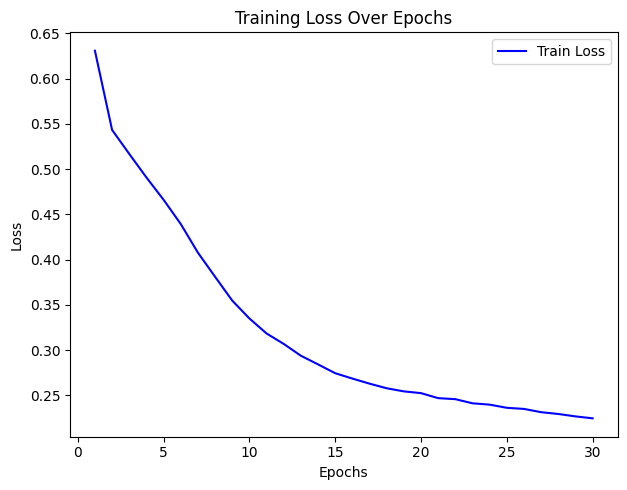

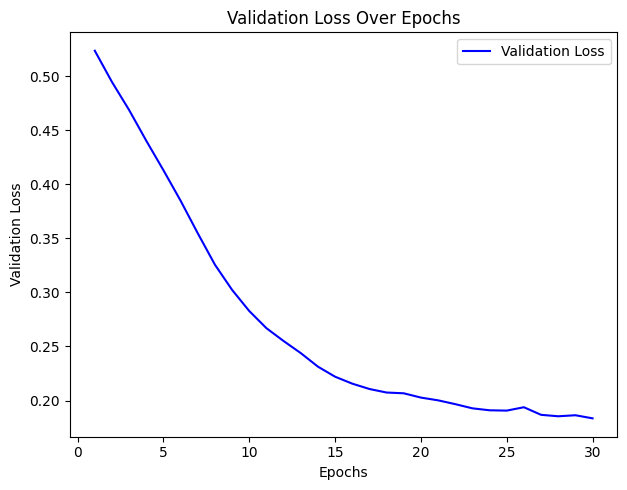

In [20]:
def plot_metrics(train_losses):
    # Convert all elements to CPU floats if they are tensors
    train_losses = [t.cpu().item() if hasattr(t, 'device') else t for t in train_losses]

    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    
    plt.show()
    
    # Plot Val
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, val_losses, label='Validation Loss', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Validation Loss')
    plt.title('Validation Loss Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example call after training
plot_metrics(train_losses)

In [21]:
print(f'Last training loss: {train_losses[-1]}')
print(f'Last validation loss: {val_losses[-1]}')
#print(f'Last lr: {scheduler.get_last_lr()}')

Last training loss: 0.22474865355188883
Last validation loss: 0.1834920048713684


In [22]:
test_epochs = 1
test_losses = []

for epoch in range(test_epochs):
    
    frm_model.eval()  # Set model to evaluation mode
    test_loss = 0.0

    with torch.no_grad():  # No gradient computation
        for feature_vector, _, _ in tqdm(test_loader, desc="Testing"):
            feature_vector = feature_vector.squeeze(dim=1)
            feature_vector = feature_vector.cuda()
            
            output = frm_model(feature_vector)
            loss = criterion(feature_vector, output)
            test_loss += loss.item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)

    print(f"Test Loss: {test_loss:.4f}")

Testing: 100%|██████████| 8/8 [00:00<00:00, 75.91it/s]

Test Loss: 0.1902


# Inference:

In [5]:
import re

def process_inputs(video_inputs, sensor_inputs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Ensure tensors and on correct device
    if not isinstance(video_inputs, torch.Tensor):
        video_inputs = torch.tensor(video_inputs, dtype=torch.float32).to(device)
    else:
        video_inputs = video_inputs.to(device)

    if not isinstance(sensor_inputs, torch.Tensor):
        sensor_inputs = torch.tensor(sensor_inputs, dtype=torch.float32).to(device)
    else:
        sensor_inputs = sensor_inputs.to(device)

    # Flatten both and make them 1D
    video_inputs = video_inputs.flatten()
    sensor_inputs = sensor_inputs.flatten()

    # Concatenate
    inputs = torch.cat((video_inputs, sensor_inputs), dim=0)

    return inputs

def anomaly_inference(folder_path, model):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.eval()
    model = model.to(device)

    #original_features = []
    #reconstructed_features = []

    parent_dir = os.path.dirname(folder_path)
    identifier = parent_dir.split('/')[-1].split(' ')[0]
    identifier = parent_dir.split('/')[-1].split(' ')[0]
    identifier = re.sub(r'fail', 'fail', identifier, flags=re.IGNORECASE) 

    rosbag_file = os.path.join(parent_dir, f"{identifier}.bag")

    #print(rosbag_file)

    labels = [] 
    reconstruction_errors = []

    for video in range(len(os.listdir(folder_path))):

        video_path = os.path.join(folder_path,f'clip_{video + 1}.mp4')

        base_dir = os.path.dirname(video_path).split(os.sep)
        file_name = os.path.basename(video_path)
        print(video_path)
        
        new_name = f"{base_dir[1]}_{file_name}"
        init_time, final_time = get_clip_times('fails_all_clips_timestamps.csv',new_name)

        if init_time == None:
            continue

        frames = load_video_frames(video_path, num_frames=32)
        if len(frames) > 0:

            video_inputs = preprocess_frames_2(frames).to(device)
            sensor_inputs = extract_rosbag_to_matrix_with_timegap(rosbag_file,init_time,final_time)

            if len(sensor_inputs) < 30:
                continue
            #else:
            pooled_inputs = fixed_max_pool_matrix(sensor_inputs,8)

            #print(f'Before : {len(sensor_inputs)} - After : {len(pooled_inputs)}')
            with torch.no_grad():
                output = model(video_inputs)  # Original Swin3D
                inputs = process_inputs(output,pooled_inputs)

                reconstruction_output = frm_model(inputs.unsqueeze(0))  # Reconstructed features
                reconstruction_errors.append(criterion(reconstruction_output, inputs.unsqueeze(0)).cpu().numpy())
            #original_features.append(output.cpu().numpy().squeeze())
            #reconstructed_features.append(reconstruction_output.cpu().numpy().squeeze())
            
            #labels.append(0 if (video + 1) < 6 else 1)

    reconstruction_errors = np.array(reconstruction_errors)

    percent = 0.25 
    num_normals = int(len(reconstruction_errors) * percent)

    lowest_errors = np.sort(reconstruction_errors)[:num_normals]

    threshold = np.mean(lowest_errors) + 1.5 * np.std(reconstruction_errors)

    for error in reconstruction_errors:
        if error > threshold:
            labels.append(1)
        else:
            labels.append(0)

    return reconstruction_errors, labels, threshold

def reconstruction_errors_plot (name, reconstruction_errors, threshold):
    clip_labels = [f'{i+1}' for i in range(len(reconstruction_errors))]

    plt.figure(figsize=(10, 6))
    bars = plt.bar(clip_labels, reconstruction_errors, color='skyblue')
    plt.xlabel('Clips')
    plt.ylabel('Reconstruction Error')
    plt.title(f'Reconstruction Errors / Clip - {name}')
    plt.xticks()

    # Add value labels on top of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', 
                ha='center', va='bottom', fontsize=9)

    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.2f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

def reconstruction_errors_line_plot(name, reconstruction_errors, threshold):
    clip_labels = [f'{i+1}' for i in range(len(reconstruction_errors))]

    plt.figure(figsize=(10, 6))
    plt.plot(clip_labels, reconstruction_errors, color='blue', label='Reconstruction Error')
    plt.xlabel('Clips')
    plt.ylabel('Reconstruction Error')
    plt.title(f'Reconstruction Errors / Clip - {name}')
    plt.xticks()

    # Add value labels on each point
    for i, error in enumerate(reconstruction_errors):
        plt.text(i, error, f'{error:.2f}', ha='center', va='bottom', fontsize=9)

    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.3f}')
    plt.legend()

    plt.tight_layout()
    plt.show()

def reconstruction_errors_line_plot_3(name, reconstruction_errors, threshold):
    # Ensure the output folder exists
    output_dir = "output/recon/all"
    os.makedirs(output_dir, exist_ok=True)

    clip_labels = [f'{i+1}' for i in range(len(reconstruction_errors))]

    plt.figure(figsize=(10, 6))
    plt.plot(clip_labels, reconstruction_errors, color='blue', label='Reconstruction Error')

    plt.xlabel('Clips', fontsize=14)
    plt.ylabel('Reconstruction Error', fontsize=14)
    plt.title(f'Reconstruction Errors / Clip - {name}', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add value labels on each point
    for i, error in enumerate(reconstruction_errors):
        plt.text(i, error, f'{error:.2f}', ha='center', va='bottom', fontsize=11)

    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.3f}')
    plt.legend(fontsize=12)

    plt.tight_layout()

    # Save the plot
    name = name.split('/')[1]
    filename = f"{name}_reconstruction_errors.png"
    filepath = os.path.join(output_dir, filename)
    plt.savefig(filepath, format='png')
    print(f"Plot saved to: {filepath}")

    plt.show()

def reconstruction_errors_line_plot_2(name, reconstruction_errors, threshold):
    clip_labels = [f'{i+1}' for i in range(len(reconstruction_errors))]

    plt.figure(figsize=(10, 6))
    plt.plot(clip_labels, reconstruction_errors, color='blue', label='Reconstruction Error')

    plt.xlabel('Clips', fontsize=14)
    plt.ylabel('Reconstruction Error', fontsize=14)
    plt.title(f'Reconstruction Errors / Clip - {name}', fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    # Add value labels on each point
    for i, error in enumerate(reconstruction_errors):
        plt.text(i, error, f'{error:.2f}', ha='center', va='bottom', fontsize=11)

    plt.axhline(y=threshold, color='red', linestyle='--', label=f'Threshold: {threshold:.3f}')
    plt.legend(fontsize=12)

    plt.tight_layout()
    plt.show()

def get_clip_times(csv_path, target_clip_filename):

    df = pd.read_csv(csv_path)

    match = df[df['clip_filename'] == target_clip_filename]
    
    if not match.empty:
        row = match.iloc[0]
        return float(row['start_time']), float(row['end_time'])
    else:
        return None, None


def extract_rosbag_to_matrix_with_timegap(bag_path, start_time, end_time):

    bag = rosbag.Bag(bag_path)
    data_matrix = []

    latest_gripper_position = [0, 0]

    for topic, msg, t in bag.read_messages(topics=[
        '/franka_state_controller/franka_states',
        '/franka_gripper/joint_states'
    ]):
        timestamp = t.to_sec()

        if timestamp < start_time:
            continue
        if timestamp > end_time:
            break

        if topic == '/franka_gripper/joint_states':
            latest_gripper_position = list(msg.position) if msg.position else [0, 0]

        elif topic == '/franka_state_controller/franka_states':
            tau_J = list(msg.tau_J)
            row = tau_J + latest_gripper_position
            data_matrix.append(row)

    bag.close()
    return data_matrix

def max_pool_matrix(matrix, pool_size):

    matrix = np.array(matrix)
    n_rows, _ = matrix.shape
    pooled_matrix = []

    for i in range(0, n_rows, pool_size):
        window = matrix[i:i+pool_size, :]
        if window.shape[0] == 0:
            continue

        timestamp = np.mean(window[:, 0])

        pooled_features = np.max(window[:, 1:], axis=0)

        pooled_row = [timestamp] + pooled_features.tolist()
        pooled_matrix.append(pooled_row)

    return pooled_matrix

def fixed_max_pool_matrix(matrix, output_size):
    """
    Pools the matrix into a fixed number of segments (output_size), 
    regardless of the original size.
    """
    matrix = np.array(matrix)
    n_rows, n_features = matrix.shape

    if n_rows == 0:
        return [[0] * n_features for _ in range(output_size)]  # fallback: all zeros

    pooled_matrix = []
    bin_size = n_rows / output_size

    for i in range(output_size):
        start = int(i * bin_size)
        end = int((i + 1) * bin_size)

        window = matrix[start:end]

        if window.shape[0] == 0:
            pooled_row = [0] * n_features
        else:
            timestamp = np.mean(window[:, 0])  # if timestamp is first column
            pooled_features = np.max(window[:, 1:], axis=0)
            pooled_row = [timestamp] + pooled_features.tolist()

        pooled_matrix.append(pooled_row)

    return pooled_matrix

In [8]:
checkpoint = torch.load('weights/frm_all.pt')
frm_model.load_state_dict(checkpoint)
frm_model.eval()

/tmp/ipykernel_29306/660084548.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('toledo-frm-checkpoints/with_all/checkpoint_bag_30.pt')


AutoEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=1765, out_features=1182, bias=True)
      (1): BatchNorm1d(1182, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=1182, out_features=599, bias=True)
      (1): BatchNorm1d(599, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0.1, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=599, out_features=16, bias=True)
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dropout(p=0, inplace=False)
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=16, out_features=890, bias=True)
      (1): BatchNorm1d(890, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Dr

In [9]:
import pickle

def process_inputs_2(video_inputs, sensor_inputs, sgg_inputs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- Video ---
    if not isinstance(video_inputs, torch.Tensor):
        video_inputs = torch.tensor(video_inputs, dtype=torch.float32).to(device)
    else:
        video_inputs = video_inputs.to(device)
    video_inputs = video_inputs.flatten()

    # --- Sensor ---
    if not isinstance(sensor_inputs, torch.Tensor):
        sensor_inputs = torch.tensor(sensor_inputs, dtype=torch.float32).to(device)
    else:
        sensor_inputs = sensor_inputs.to(device)
    sensor_inputs = sensor_inputs.flatten()

    # --- Scene Graph ---
    if not isinstance(sgg_inputs, torch.Tensor):
        sgg_inputs = torch.tensor(sgg_inputs, dtype=torch.float32).to(device)
    else:
        sgg_inputs = sgg_inputs.to(device)
    sgg_inputs = sgg_inputs.flatten()

    # --- Concatenate all modalities ---
    inputs = torch.cat((video_inputs, sensor_inputs, sgg_inputs), dim=0)

    return inputs

def anomaly_inference_2(folder_path, model, sgg_file, video_name):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.eval()
    model = model.to(device)

    #original_features = []
    #reconstructed_features = []

    parent_dir = os.path.dirname(folder_path)
    identifier = parent_dir.split('/')[-1].split(' ')[0]
    identifier = parent_dir.split('/')[-1].split(' ')[0]
    identifier = re.sub(r'fail', 'fail', identifier, flags=re.IGNORECASE) 

    rosbag_file = os.path.join(parent_dir, f"{identifier}.bag")

    #print(rosbag_file)

    with open(sgg_file, "rb") as f:
        fail_sgg_df = pickle.load(f)
    
    sgg_map = {clip: vec for clip, vec in zip(fail_sgg_df["Clip"], fail_sgg_df["Matrix"])}
    # Joao_4_fail - Joint Torque_clip_10.mp4
    
    labels = [] 
    reconstruction_errors = []

    for video in range(len(os.listdir(folder_path))):
        sgg_name = video_name + f'_clip_{video + 1}.mp4'

        video_path = os.path.join(folder_path,f'clip_{video + 1}.mp4')

        base_dir = os.path.dirname(video_path).split(os.sep)
        file_name = os.path.basename(video_path)
        
        new_name = f"{base_dir[1]}_{file_name}"
        init_time, final_time = get_clip_times('fails_all_clips_timestamps.csv',new_name)

        if init_time == None:
            continue

        frames = load_video_frames(video_path, num_frames=32)
        if len(frames) > 0:

            video_inputs = preprocess_frames_2(frames).to(device)
            sensor_inputs = extract_rosbag_to_matrix_with_timegap(rosbag_file,init_time,final_time)

            if len(sensor_inputs) < 30:
                continue
            #else:
            pooled_inputs = fixed_max_pool_matrix(sensor_inputs,8)

            #print(f'Before : {len(sensor_inputs)} - After : {len(pooled_inputs)}')
            with torch.no_grad():
                output = model(video_inputs)  # Original Swin3D
                inputs = process_inputs_2(output,pooled_inputs, sgg_map[sgg_name])

                reconstruction_output = frm_model(inputs.unsqueeze(0))  # Reconstructed features
                reconstruction_errors.append(criterion(reconstruction_output, inputs.unsqueeze(0)).cpu().numpy())
            #original_features.append(output.cpu().numpy().squeeze())
            #reconstructed_features.append(reconstruction_output.cpu().numpy().squeeze())
            
            #labels.append(0 if (video + 1) < 6 else 1)

    reconstruction_errors = np.array(reconstruction_errors)

    percent = 0.25 
    num_normals = int(len(reconstruction_errors) * percent)

    lowest_errors = np.sort(reconstruction_errors)[:num_normals]

    threshold = np.mean(lowest_errors) + 1.5 * np.std(reconstruction_errors)

    for error in reconstruction_errors:
        if error > threshold:
            labels.append(1)
        else:
            labels.append(0)

    return reconstruction_errors, labels, threshold

Plot saved to: output/recon/all/Joao_4_fail - Joint Torque_reconstruction_errors.png


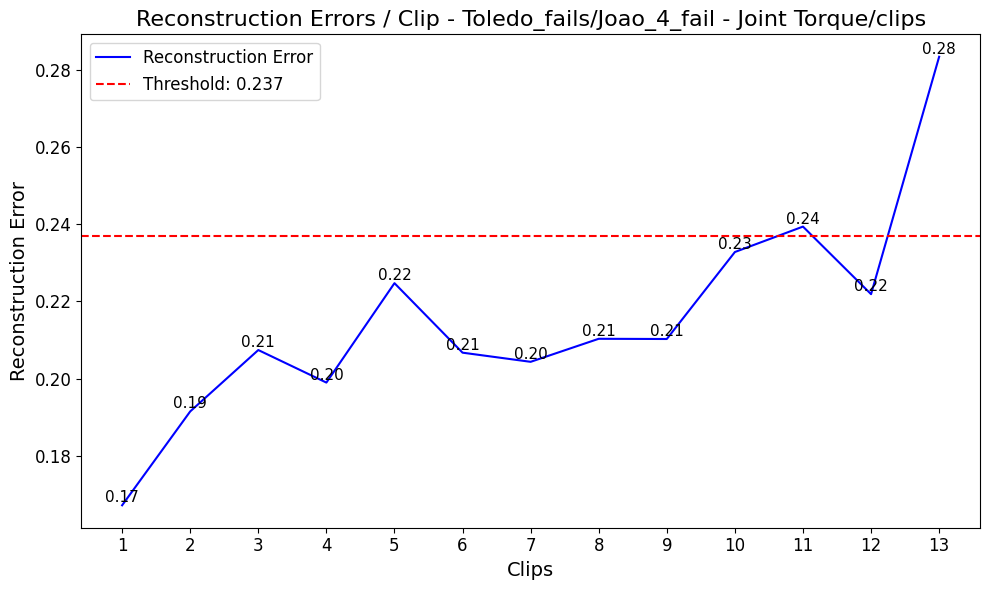

Plot saved to: output/recon/all/6_Gui_Fail - Robot human handover_reconstruction_errors.png


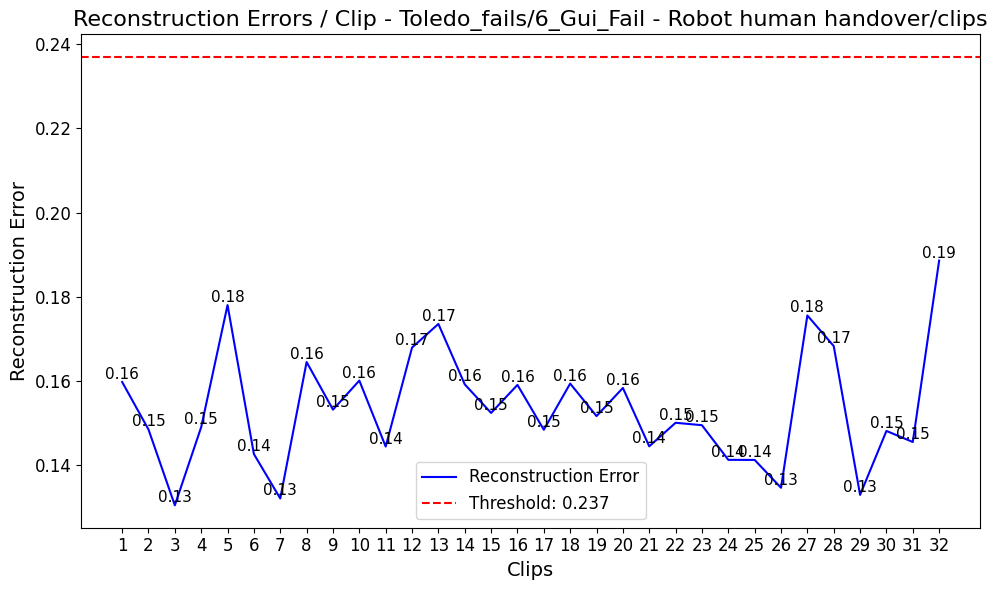

Plot saved to: output/recon/all/8_p1_fail - drop cup_reconstruction_errors.png


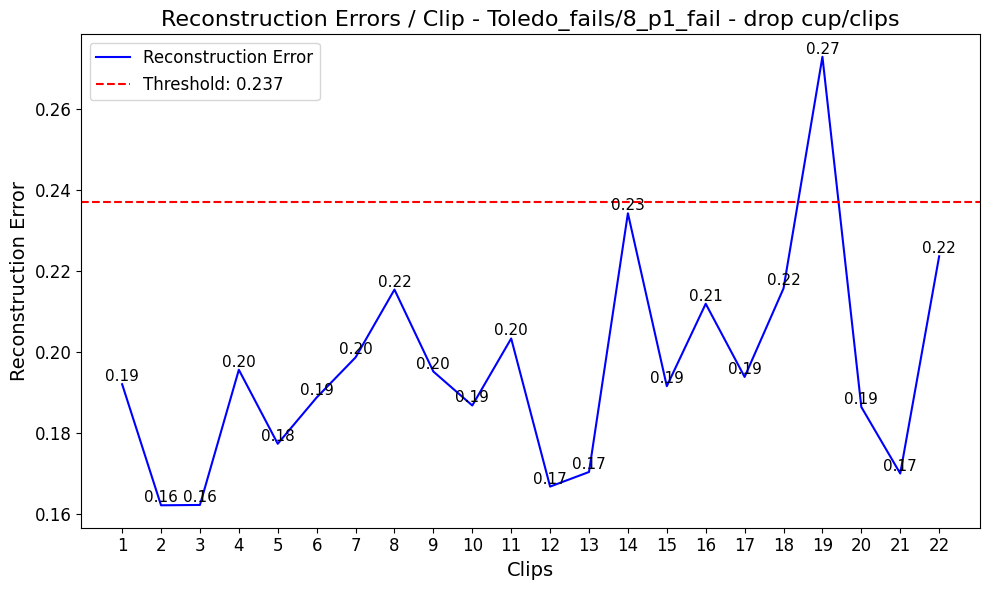

Plot saved to: output/recon/all/Gui_Fail - Inside the tube_reconstruction_errors.png


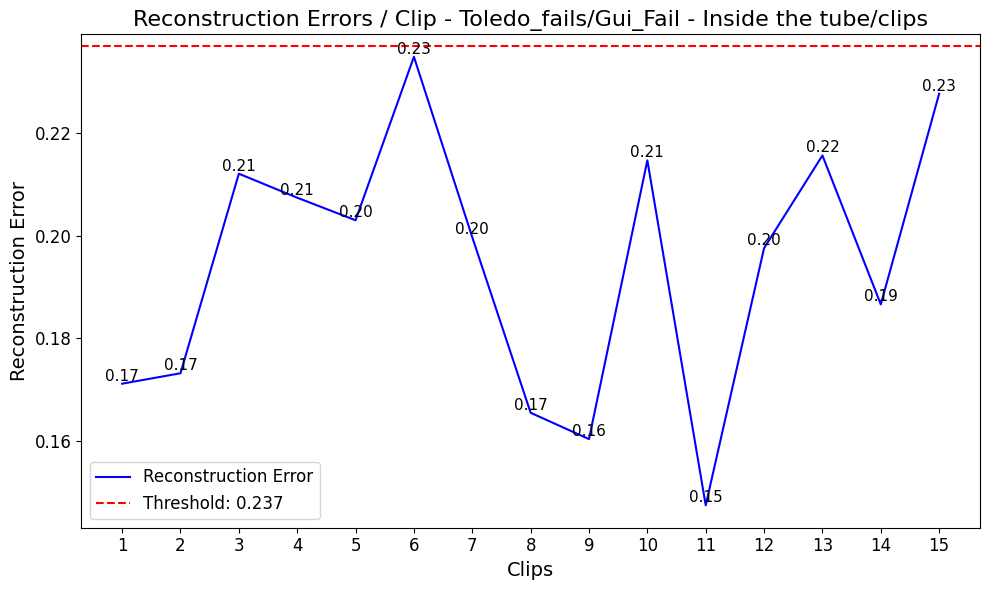

Plot saved to: output/recon/all/10_Gui_Fail_2 - Fail to grasp cup_reconstruction_errors.png


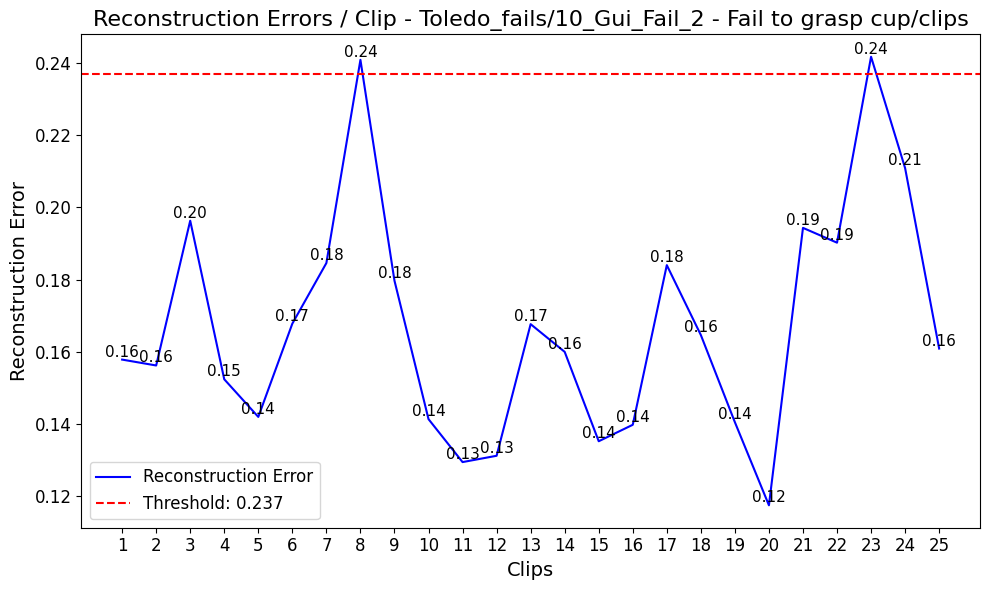

Plot saved to: output/recon/all/10_Gui_Fail - Extra person_reconstruction_errors.png


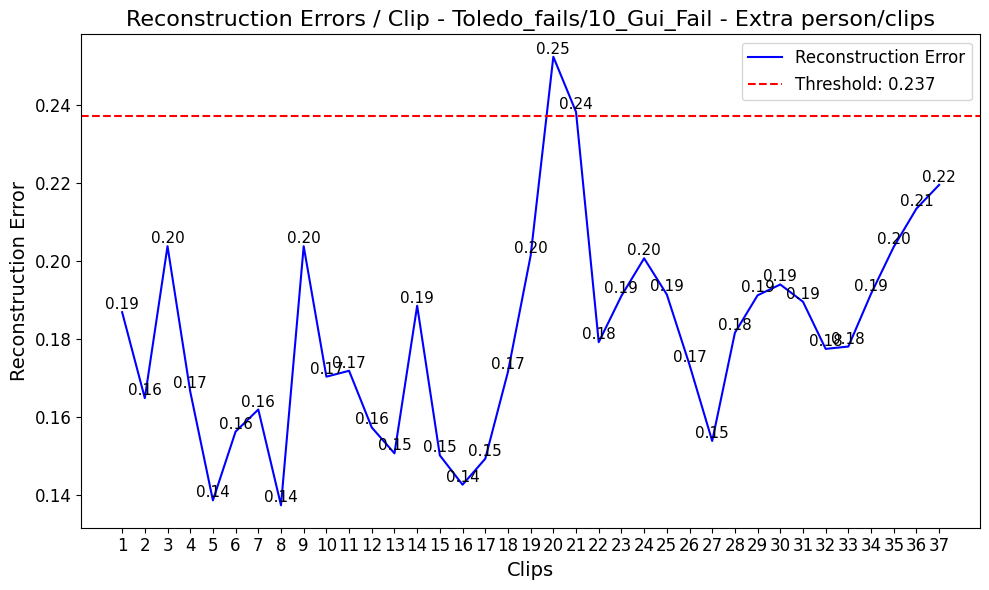

Plot saved to: output/recon/all/7_Gui_Fail - joint torque_reconstruction_errors.png


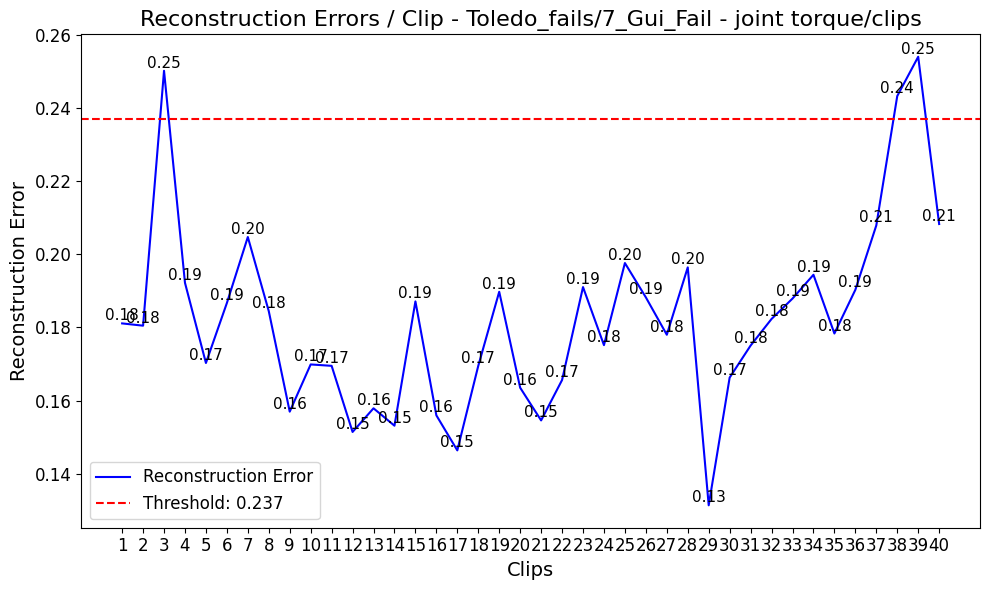

Plot saved to: output/recon/all/Joao_2_fail - Collision_reconstruction_errors.png


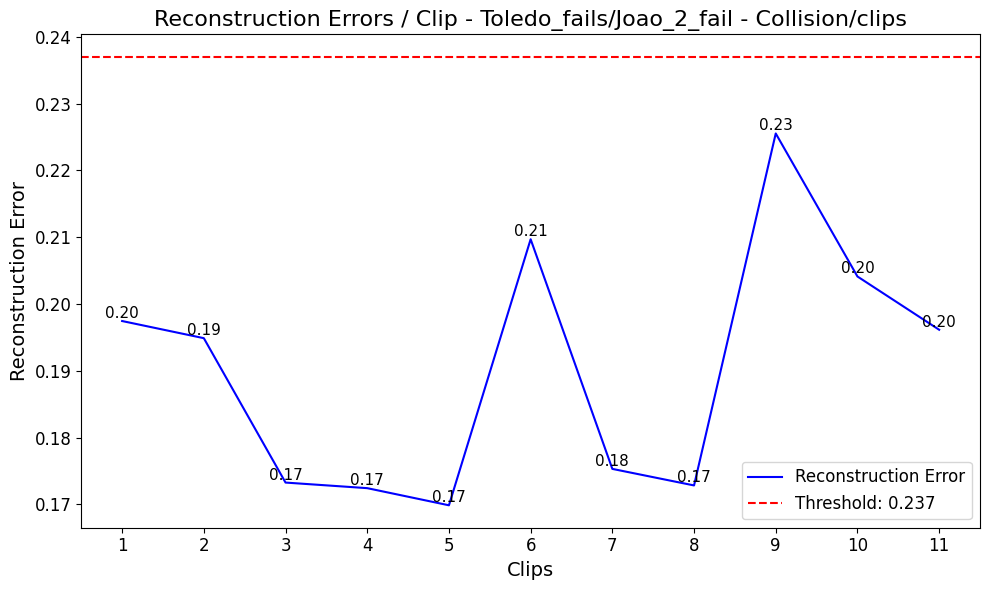

Plot saved to: output/recon/all/10_Joao_fail_reconstruction_errors.png


/home/lasige/.conda/envs/g_ribeiro/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lasige/.conda/envs/g_ribeiro/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/lasige/.conda/envs/g_ribeiro/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lasige/.conda/envs/g_ribeiro/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/lasige/.conda/envs/g_ribeiro/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


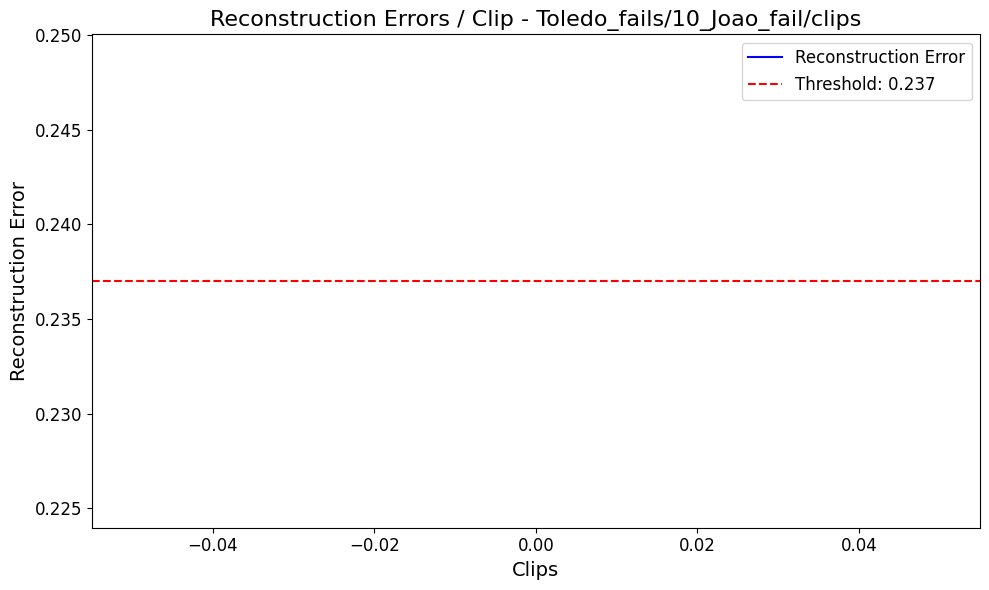

Plot saved to: output/recon/all/Joao_5_fail - fail to grasp cup_reconstruction_errors.png


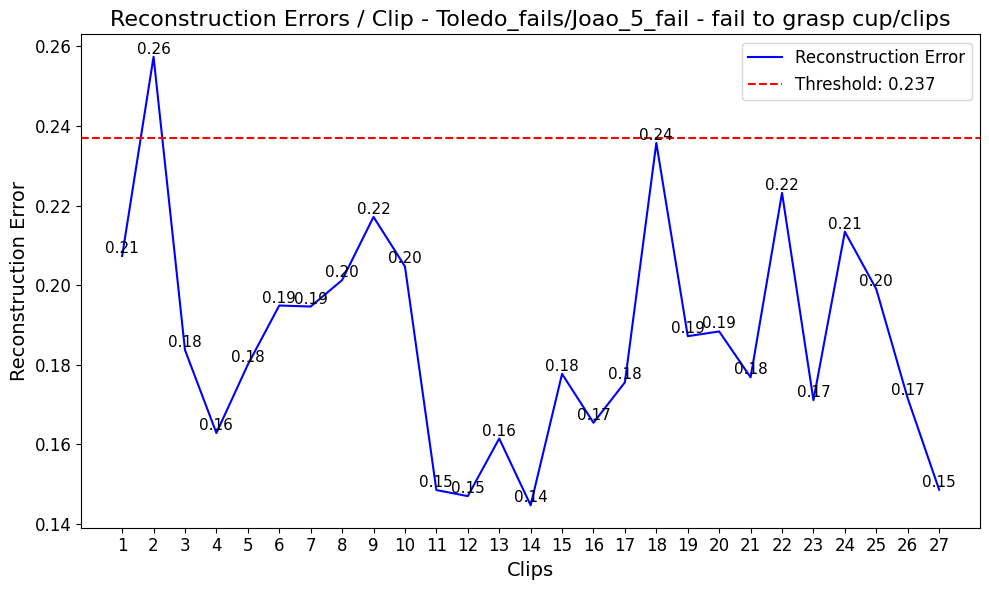

Plot saved to: output/recon/all/4_Hugo_fail - drop_reconstruction_errors.png


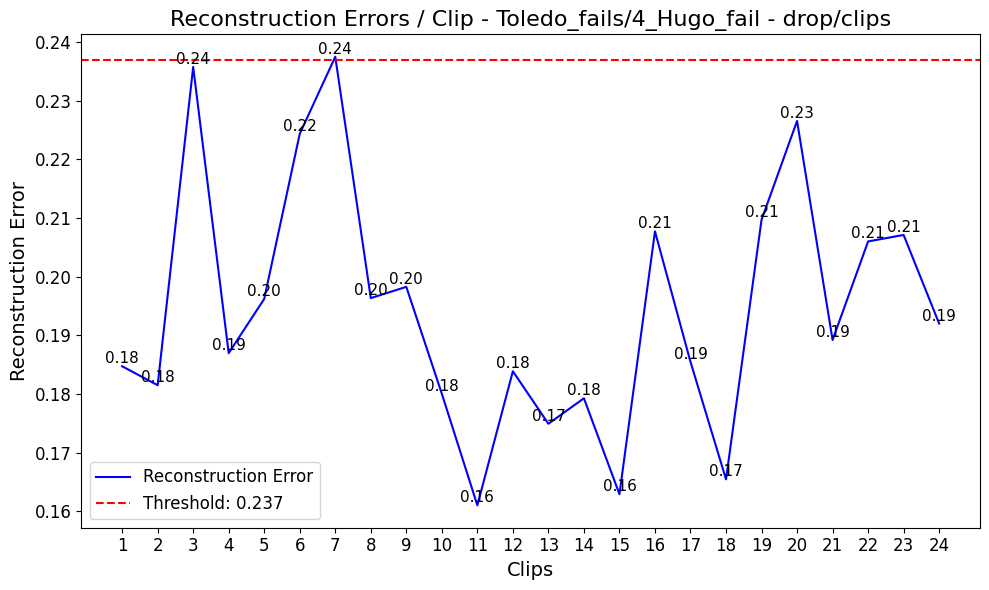

Plot saved to: output/recon/all/fun_reconstruction_errors.png


/home/lasige/.conda/envs/g_ribeiro/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lasige/.conda/envs/g_ribeiro/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/lasige/.conda/envs/g_ribeiro/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/lasige/.conda/envs/g_ribeiro/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/home/lasige/.conda/envs/g_ribeiro/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


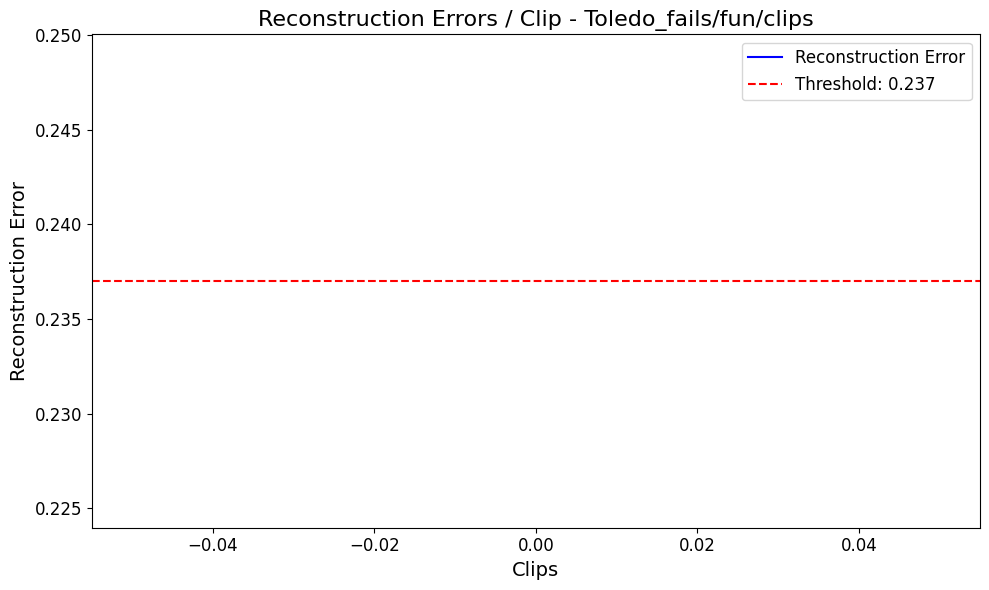

Plot saved to: output/recon/all/3_p2_fail - robot human handover_reconstruction_errors.png


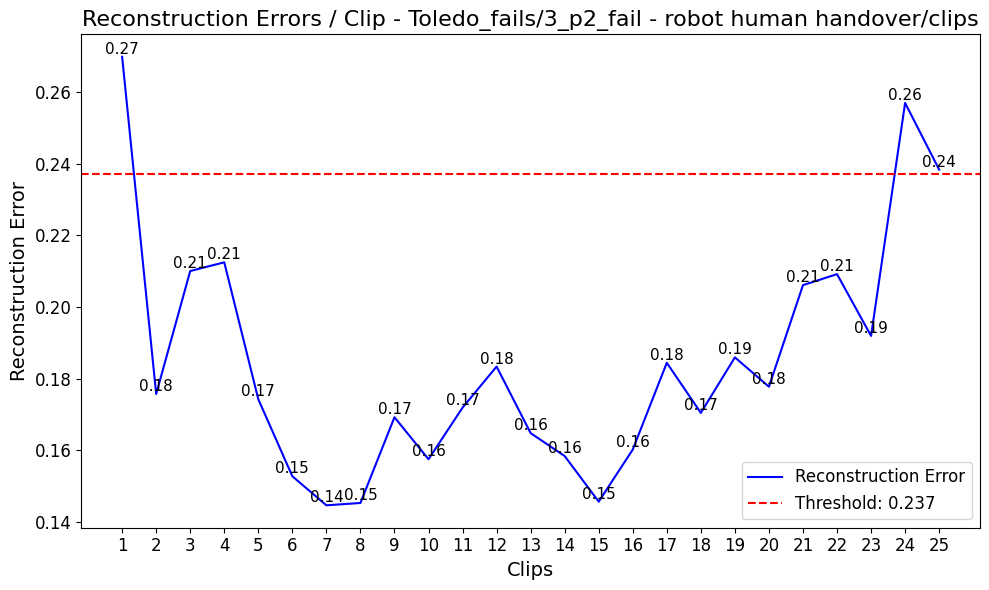

Plot saved to: output/recon/all/Joao_1_fail - Drop Cup_reconstruction_errors.png


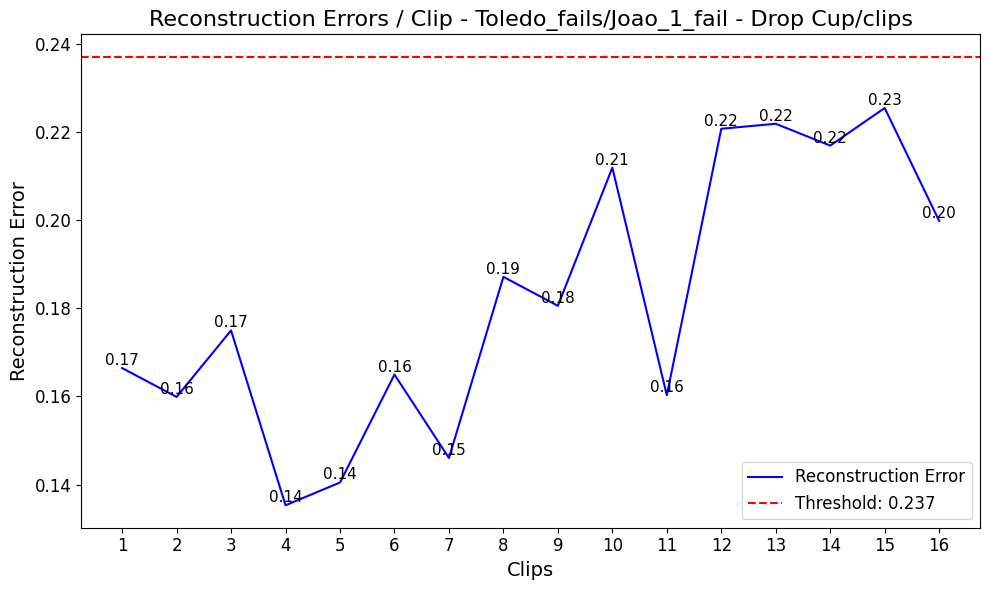

Plot saved to: output/recon/all/Joao_3_fail - Collision_reconstruction_errors.png


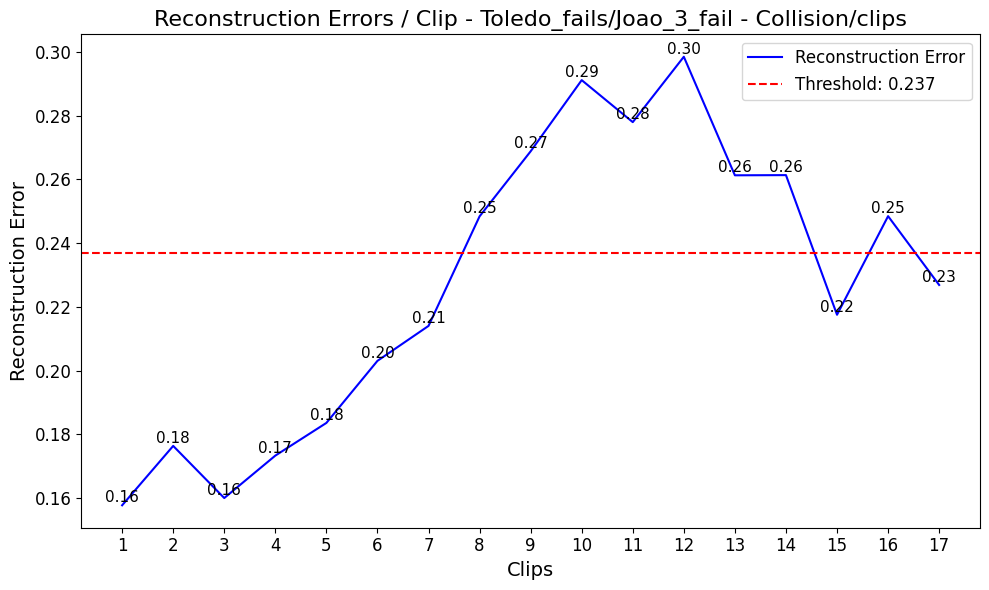

Plot saved to: output/recon/all/Gui_Fail_2 - Inside the tube_reconstruction_errors.png


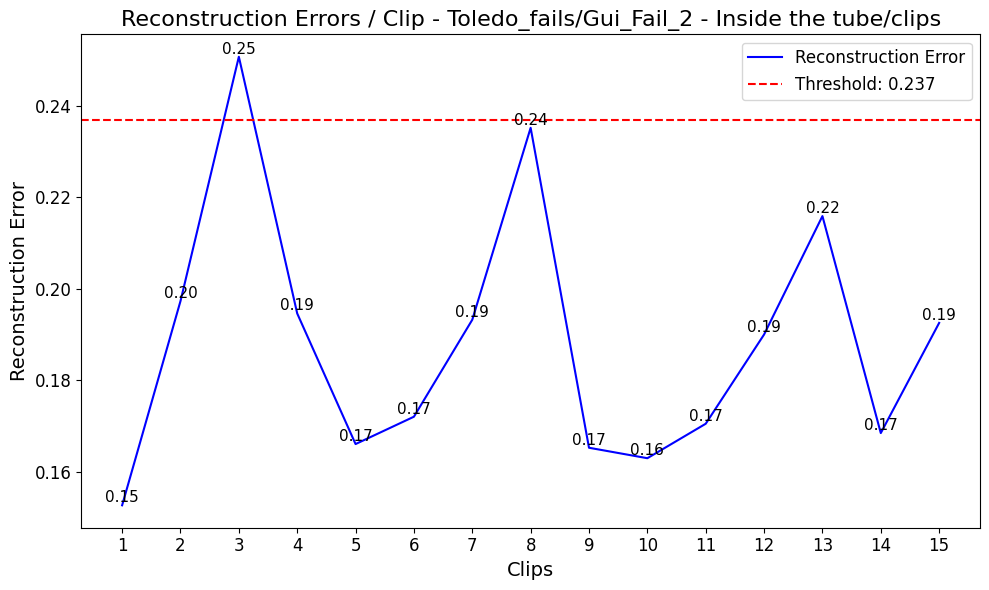

Plot saved to: output/recon/all/1_p2_fail - drop cup_reconstruction_errors.png


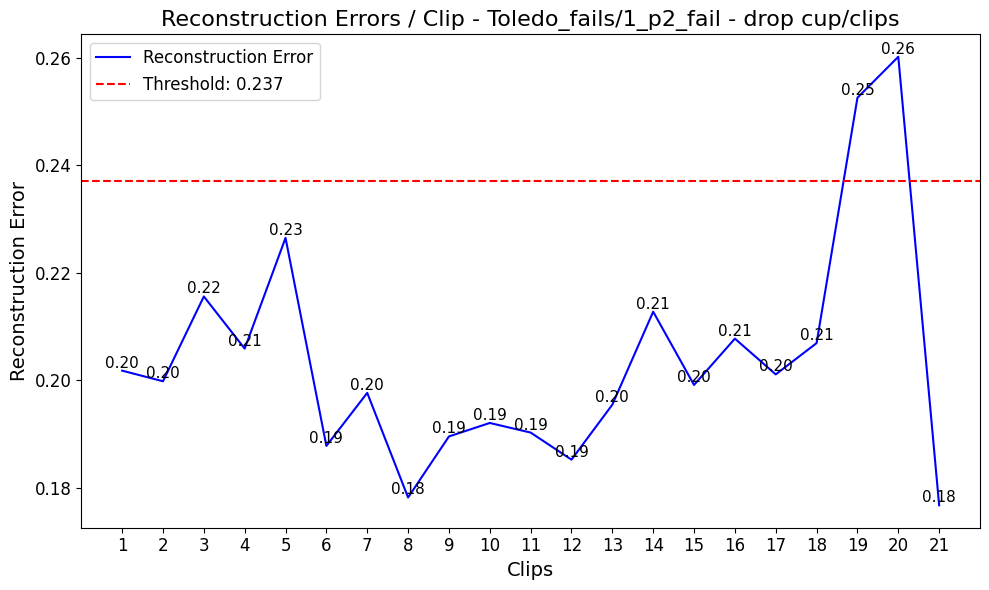

Plot saved to: output/recon/all/Gui_Fail_3 - Person Disappears_reconstruction_errors.png


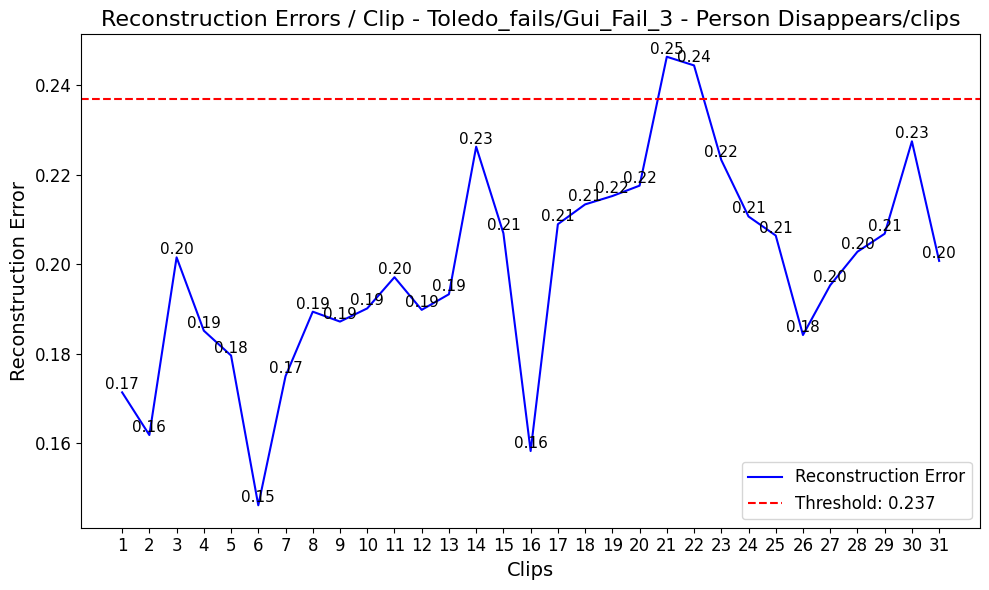

In [10]:
main = 'Toledo_fails'
all_recons_errors = {}
for video in os.listdir(main):
    if video == '9_p1_fail - drop cup':
        continue
    video_path = os.path.join(main, video, 'clips')
    model.eval()
    reconstruction_errors, labels, threshold = anomaly_inference_2(folder_path=video_path, 
                                                                   model=model,
                                                                   sgg_file='fail_scene_vectors.pkl',
                                                                   video_name = video)
    
    all_recons_errors[video_path] = reconstruction_errors

    reconstruction_errors_line_plot_3(video_path, reconstruction_errors, 0.237)

In [13]:
print(all_recons_errors)

{'Toledo_fails/Joao_4_fail - Joint Torque/clips': array([0.16722918, 0.19152822, 0.20741731, 0.19899319, 0.22472613,
       0.2067352 , 0.20436691, 0.21032804, 0.21027292, 0.23278989,
       0.23936927, 0.22187881, 0.28333178], dtype=float32), 'Toledo_fails/6_Gui_Fail - Robot human handover/clips': array([0.15980084, 0.14852946, 0.1305251 , 0.1490833 , 0.17805581,
       0.14269003, 0.13214204, 0.16453397, 0.15323526, 0.16013187,
       0.14446609, 0.1679614 , 0.17357631, 0.15923232, 0.15244874,
       0.15910469, 0.14845884, 0.15941903, 0.15169904, 0.1583854 ,
       0.1445306 , 0.15011401, 0.14953631, 0.14131533, 0.1412939 ,
       0.134684  , 0.1755877 , 0.16832669, 0.1329955 , 0.14817733,
       0.14555256, 0.1886228 ], dtype=float32), 'Toledo_fails/8_p1_fail - drop cup/clips': array([0.19200712, 0.16209403, 0.16217764, 0.19557151, 0.17729579,
       0.18871841, 0.19863434, 0.21538618, 0.19513701, 0.18674885,
       0.20329945, 0.16671692, 0.17032056, 0.23423854, 0.19152065,
      

In [10]:
import numpy as np

normalized_dict = {}
for k, v in all_recons_errors.items():
    if v.size == 0:  # empty vector
        normalized_dict[k] = v  # keep as-is (or np.zeros_like(v))
    elif v.max() == v.min():  # constant vector
        normalized_dict[k] = np.zeros_like(v)  # or keep v
    else:
        normalized_dict[k] = (v - v.min()) / (v.max() - v.min())

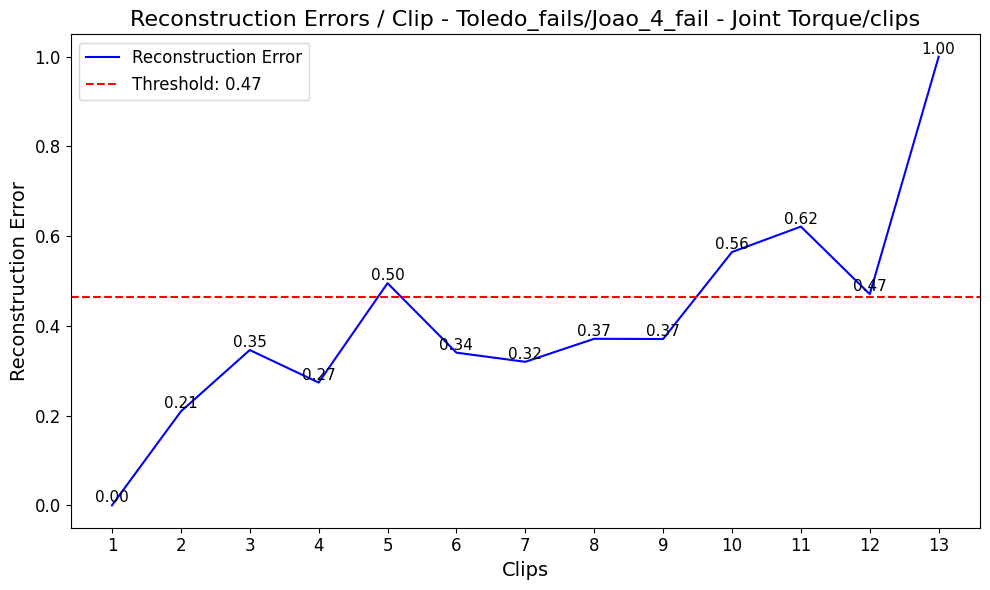

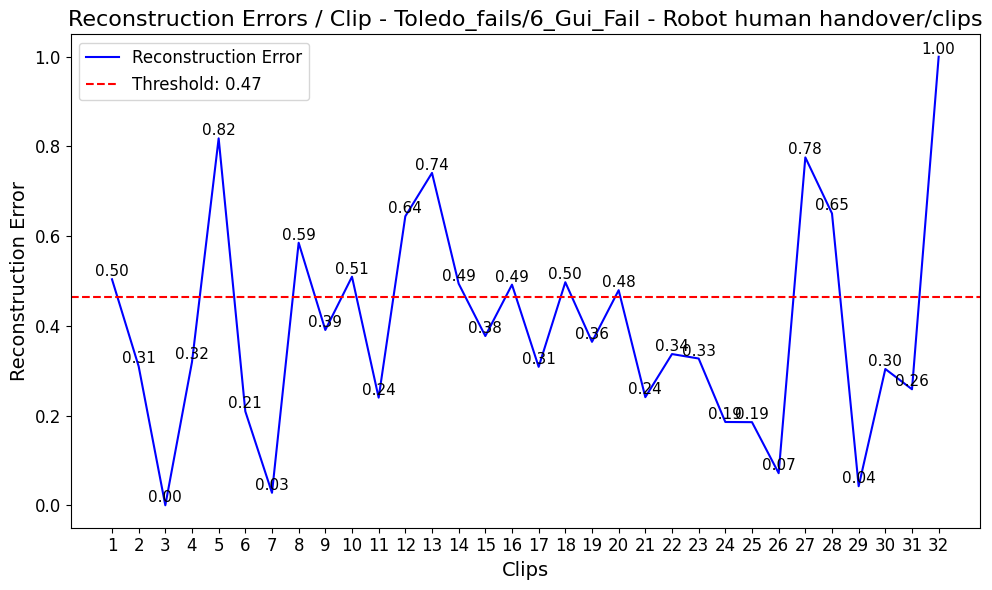

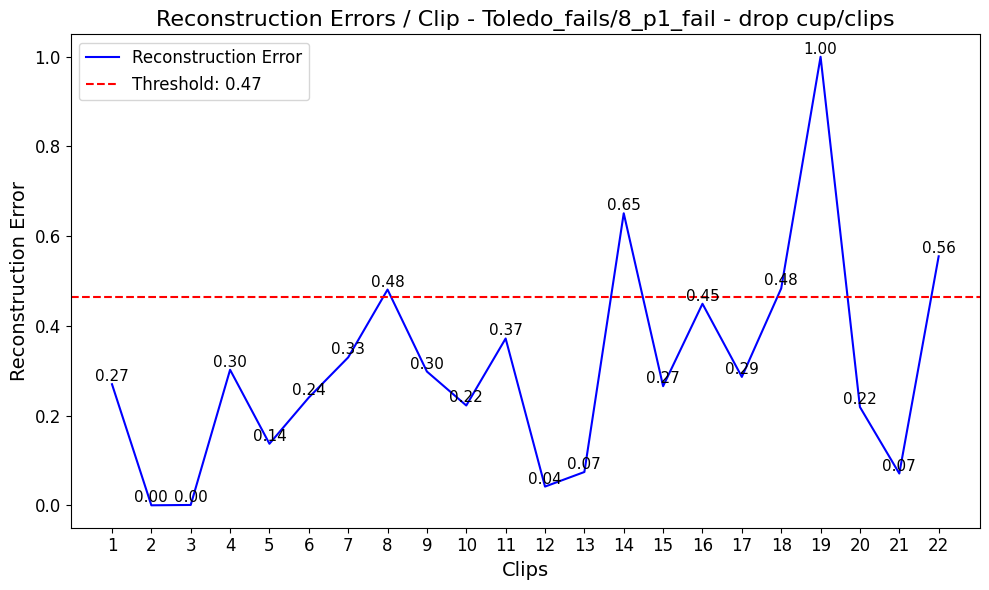

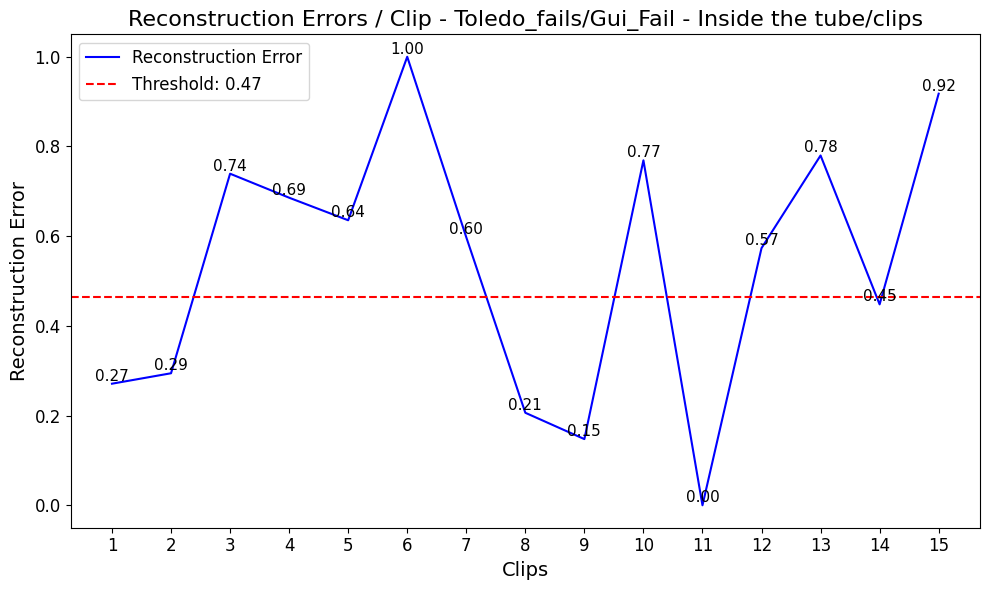

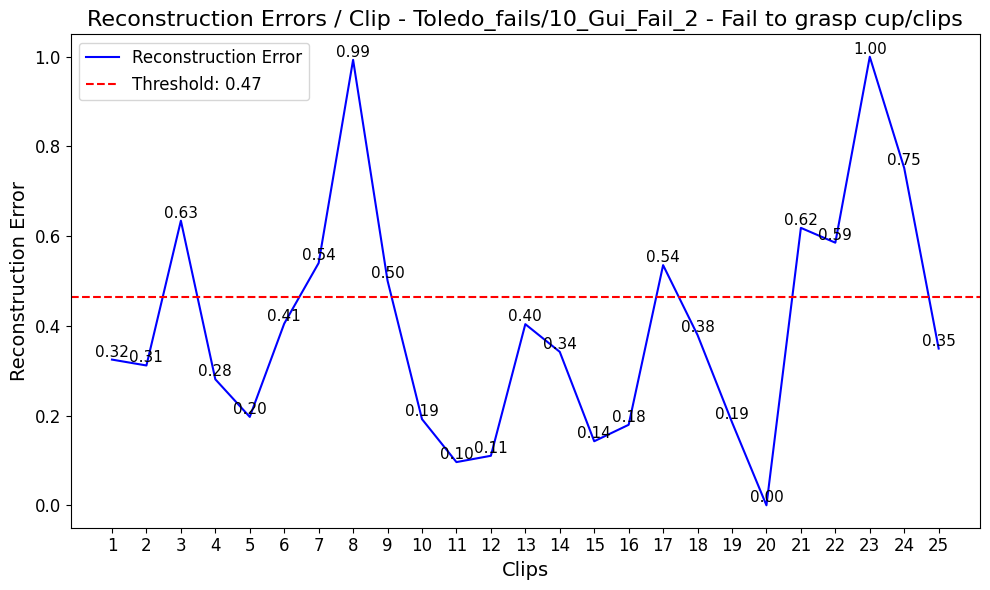

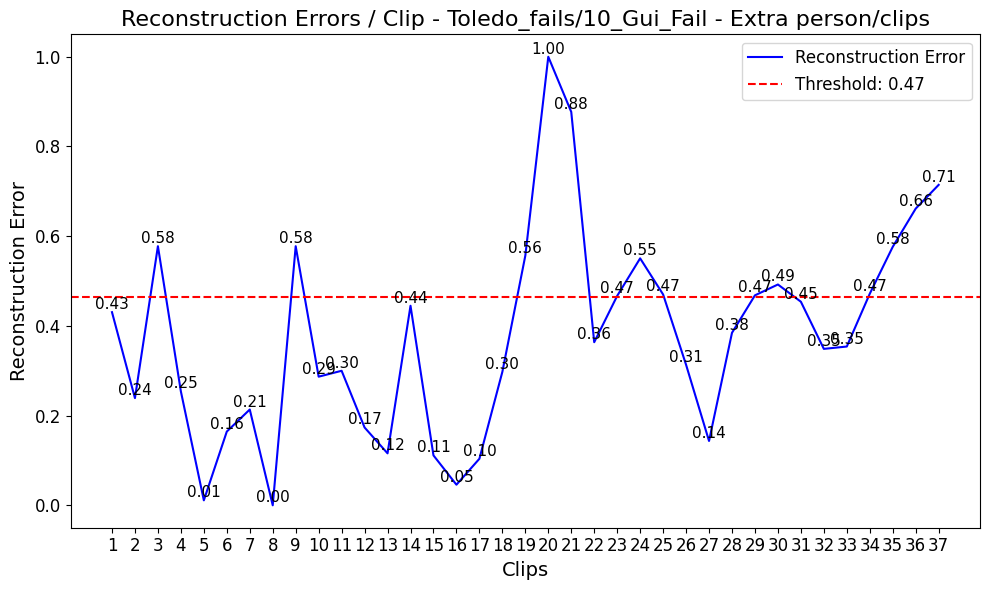

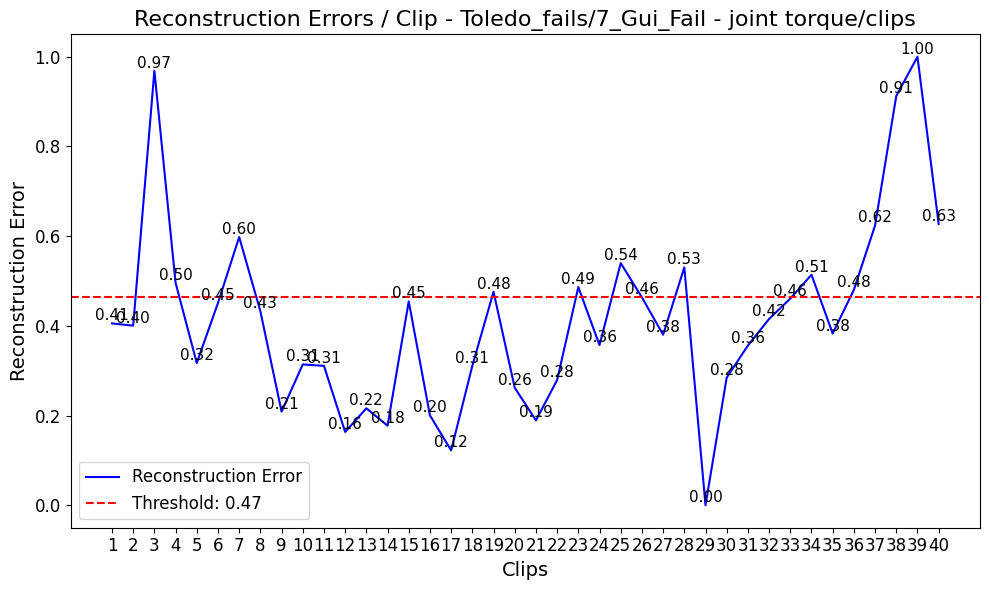

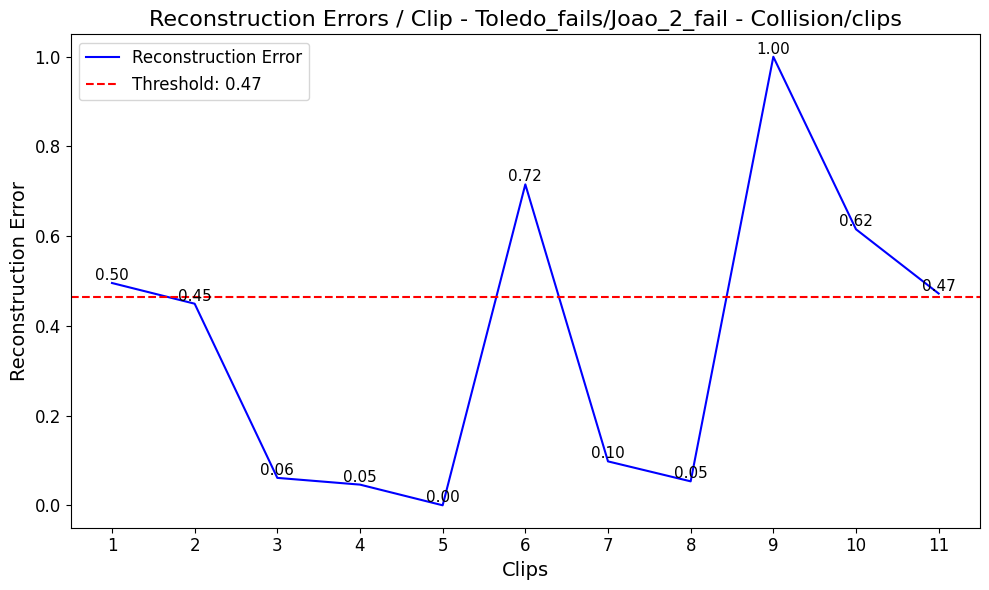

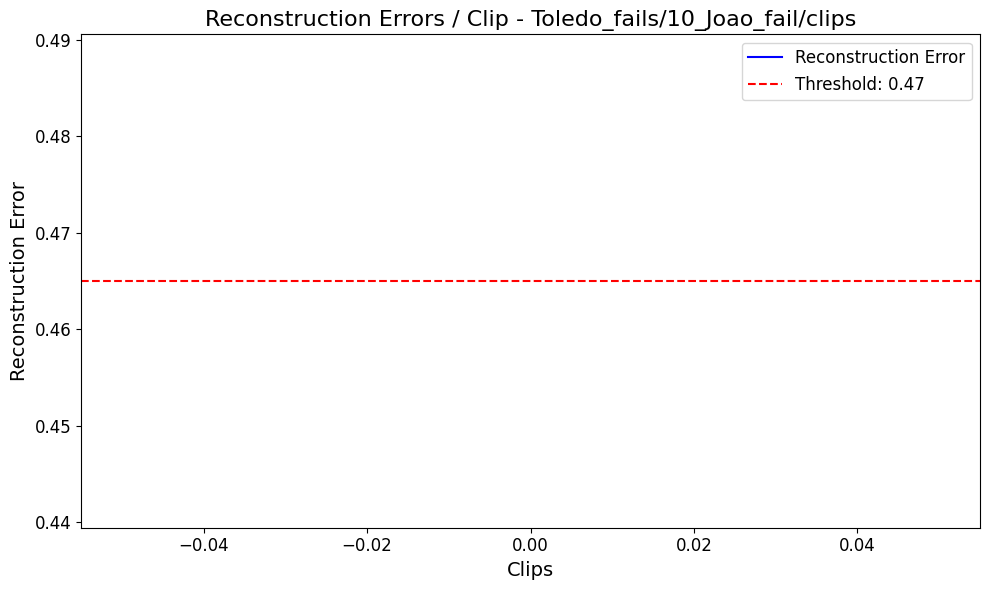

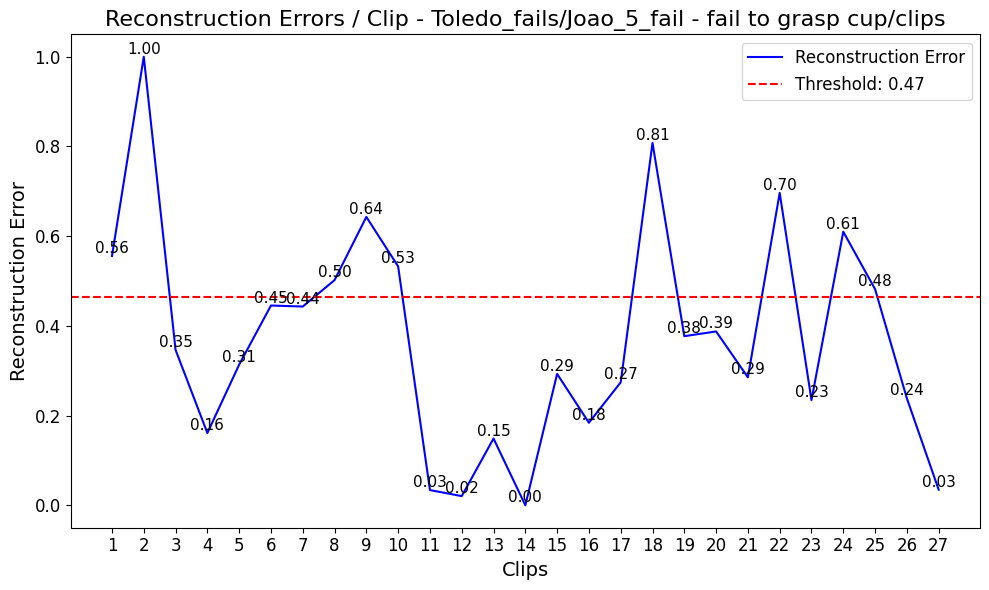

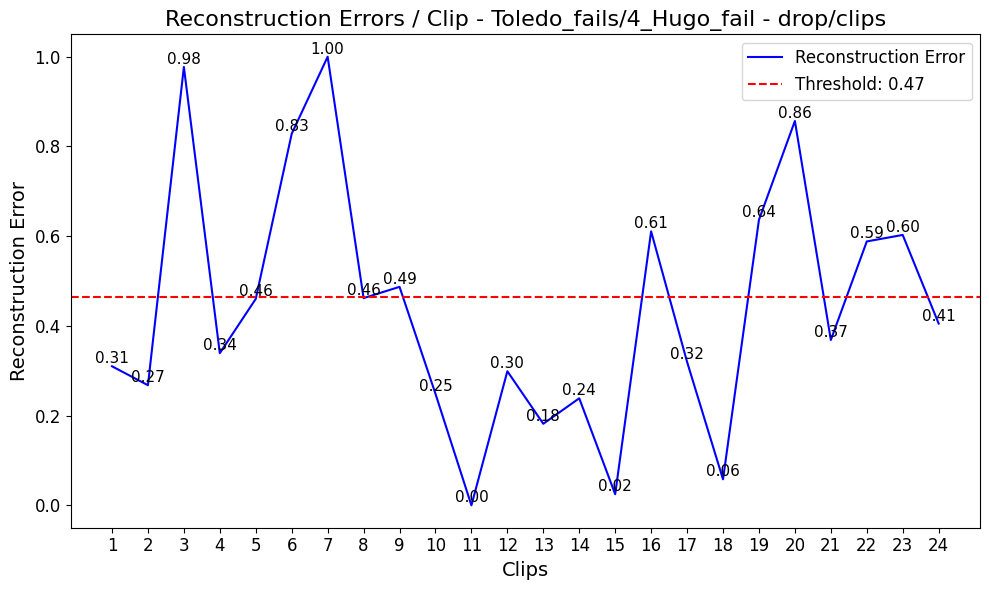

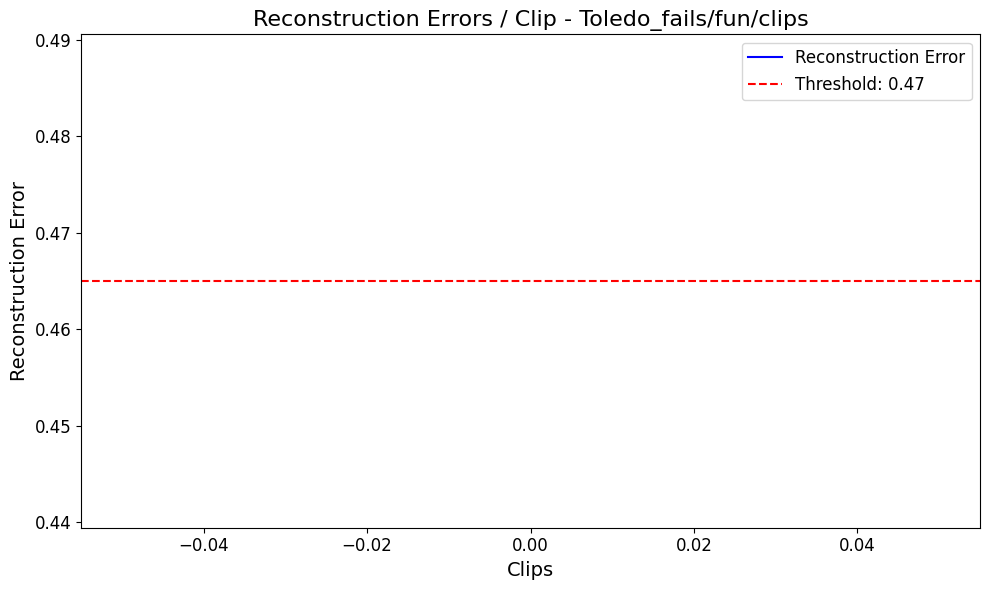

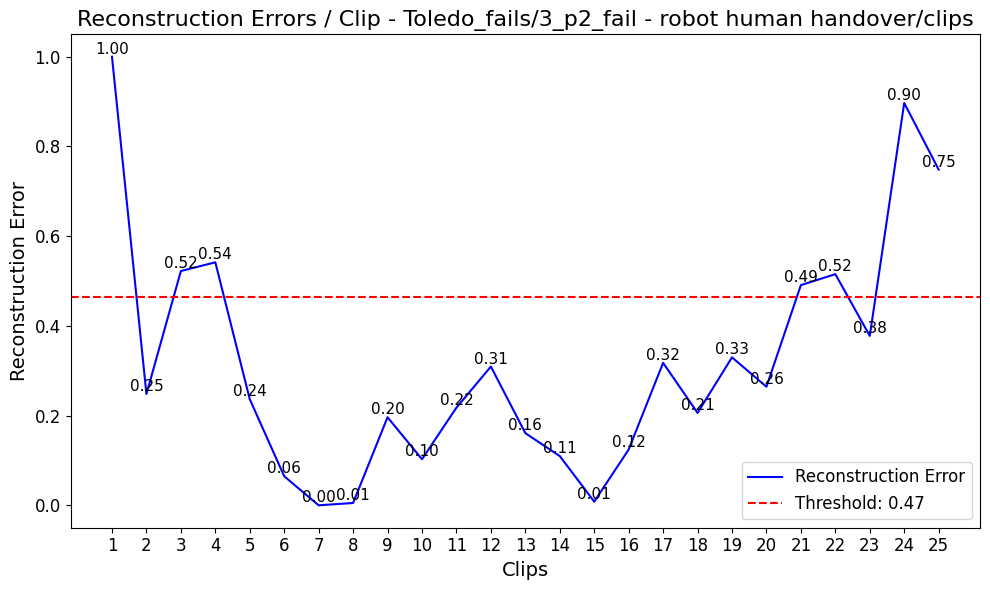

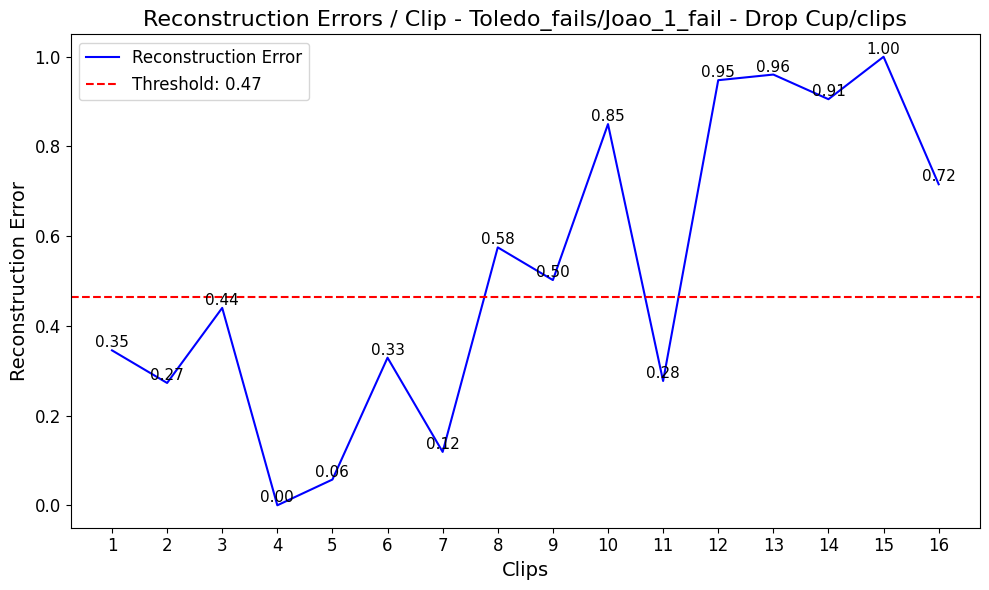

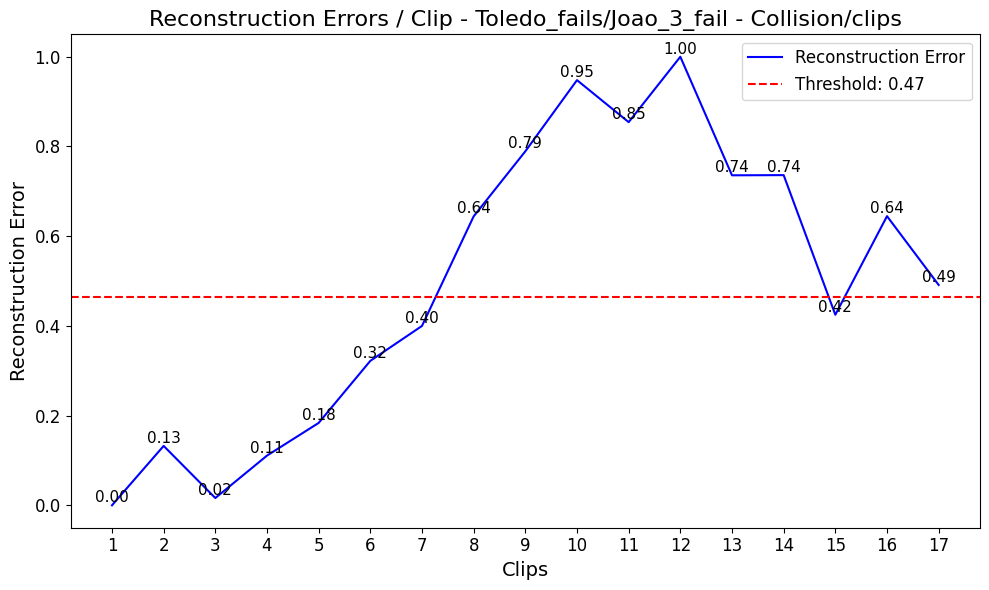

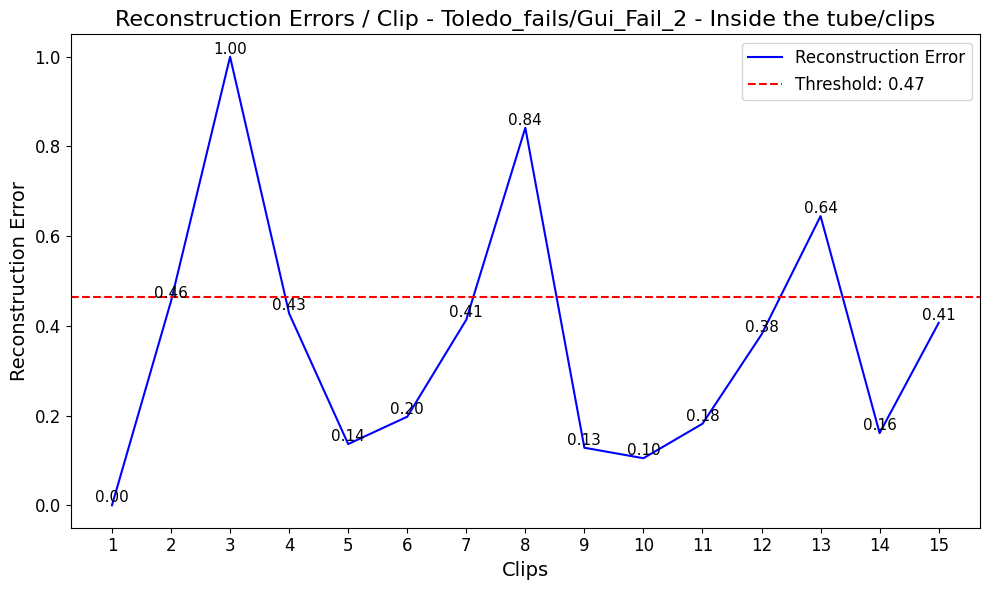

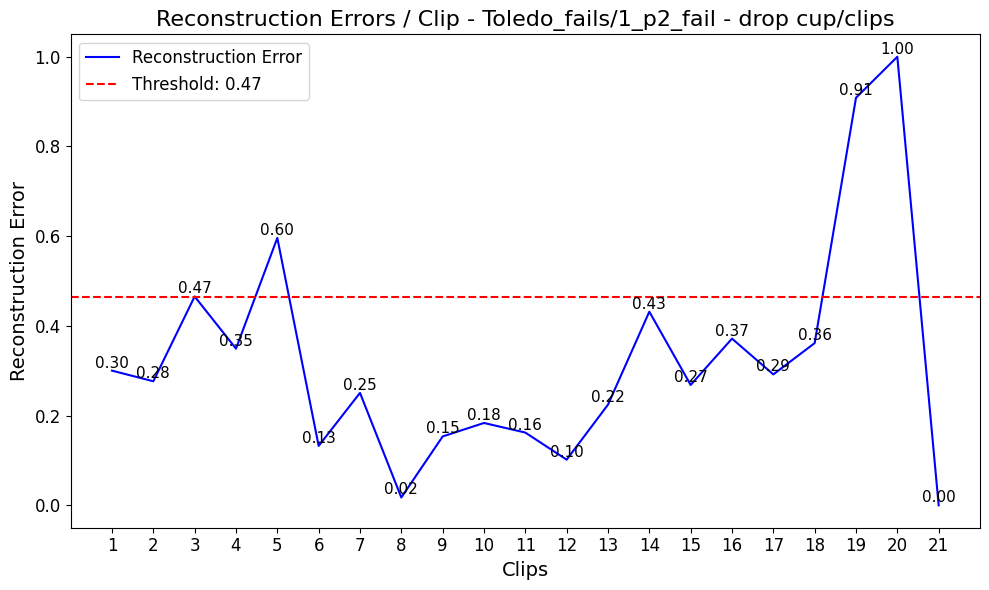

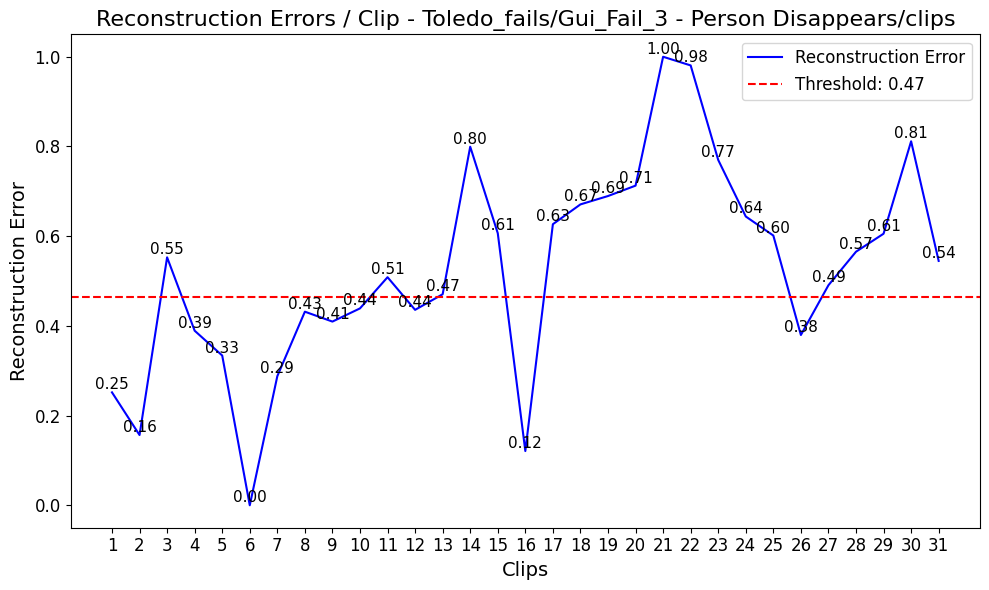

In [11]:
for k,v in normalized_dict.items():
    reconstruction_errors_line_plot_2(k,v,0.465)

In [12]:
total = 0
for k,v in normalized_dict.items():
    print(f'{k} : {len(v)}')
    total += len(v)
print(total)

Toledo_fails/Joao_4_fail - Joint Torque/clips : 13
Toledo_fails/6_Gui_Fail - Robot human handover/clips : 32
Toledo_fails/8_p1_fail - drop cup/clips : 22
Toledo_fails/Gui_Fail - Inside the tube/clips : 15
Toledo_fails/10_Gui_Fail_2 - Fail to grasp cup/clips : 25
Toledo_fails/10_Gui_Fail - Extra person/clips : 37
Toledo_fails/7_Gui_Fail - joint torque/clips : 40
Toledo_fails/Joao_2_fail - Collision/clips : 11
Toledo_fails/10_Joao_fail/clips : 0
Toledo_fails/Joao_5_fail - fail to grasp cup/clips : 27
Toledo_fails/4_Hugo_fail - drop/clips : 24
Toledo_fails/fun/clips : 0
Toledo_fails/3_p2_fail - robot human handover/clips : 25
Toledo_fails/Joao_1_fail - Drop Cup/clips : 16
Toledo_fails/Joao_3_fail - Collision/clips : 17
Toledo_fails/Gui_Fail_2 - Inside the tube/clips : 15
Toledo_fails/1_p2_fail - drop cup/clips : 21
Toledo_fails/Gui_Fail_3 - Person Disappears/clips : 31
371


In [13]:
anomaly_mask = [0,0,0,0,1,1,1,1,1,1,1,1,1, # 13
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,# 32
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1, # 22
                0,0,0,0,0,0,0,0,0,0,0,1,1,1,1, # 15
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1, # 25
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1, # 37
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1, #40
                0,0,0,0,0,0,0,0,0,1,1, # 11
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1, # 27
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1, # 24
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1, # 25
                0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1, # 16
                0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1, # 17
                0,0,0,0,0,0,0,0,0,0,0,1,1,1,1, # 15
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1, # 21
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1] #31 

anomaly_mask = np.array(anomaly_mask, dtype=bool)


In [14]:
all_values = np.concatenate(list(normalized_dict.values()))

normal_values = all_values[~anomaly_mask]
anomalous_values = all_values[anomaly_mask]

mean = all_values.mean()
normal_values_mean = normal_values.mean()
anomalous_values_mean = anomalous_values.mean()

std = all_values.std()
normal_values_std = normal_values.std()
anomalous_values_std = anomalous_values.std()

percentiles = np.percentile(all_values, [25, 50, 75, 90, 95, 99])
normal_values_percentiles = np.percentile(normal_values, [25, 50, 75, 90, 95, 99])
anomalous_values_percentiles = np.percentile(anomalous_values, [25, 50, 75, 90, 95, 99])

print(f'Mean: {mean} ; Std : {std} ; Percentiles : {percentiles}')

print(f'NORMAL : Mean: {normal_values_mean} ; Std : {normal_values_std} ; Percentiles : {normal_values_percentiles}')
print(f'ANOMALOUS : Mean: {anomalous_values_mean} ; Std : {anomalous_values_std} ; Percentiles : {anomalous_values_percentiles}')

Mean: 0.40837028318315727 ; Std : 0.26271580801482236 ; Percentiles : [0.21146107 0.37703797 0.56501102 0.79943651 0.9730247  1.        ]
NORMAL : Mean: 0.34997765274337406 ; Std : 0.24205992356724876 ; Percentiles : [0.18174968 0.31131528 0.48289166 0.65087256 0.8477874  1.        ]
ANOMALOUS : Mean: 0.604844310309957 ; Std : 0.23243778338949744 ; Percentiles : [0.45381892 0.58825475 0.74840796 0.9922713  1.         1.        ]


In [15]:
normal_values = all_values[~anomaly_mask]
anomalous_values = all_values[anomaly_mask]

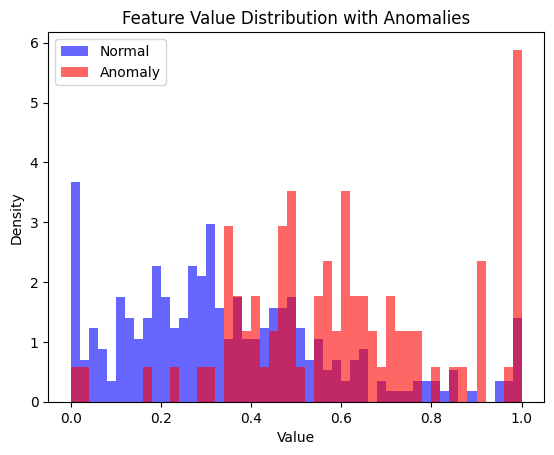

In [16]:
plt.hist(normal_values, bins=50, alpha=0.6, label="Normal", density=True, color="blue")
plt.hist(anomalous_values, bins=50, alpha=0.6, label="Anomaly", density=True, color="red")

plt.title("Feature Value Distribution with Anomalies")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

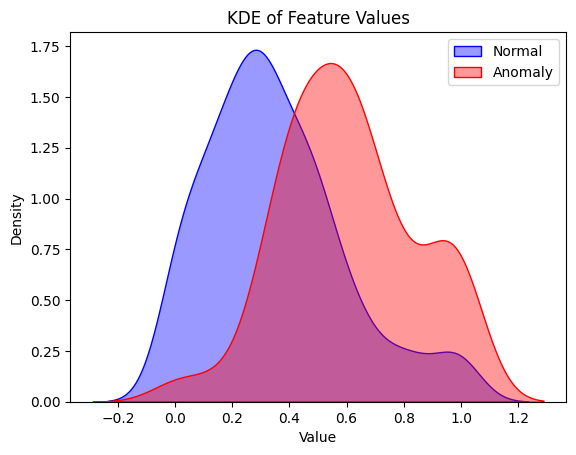

In [17]:
import seaborn as sns

sns.kdeplot(normal_values, label="Normal", color="blue", fill=True, alpha=0.4)
sns.kdeplot(anomalous_values, label="Anomaly", color="red", fill=True, alpha=0.4)

plt.title("KDE of Feature Values")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

Best threshold: 0.465, F1 = 0.549, Precision = 0.440, Recall = 0.729


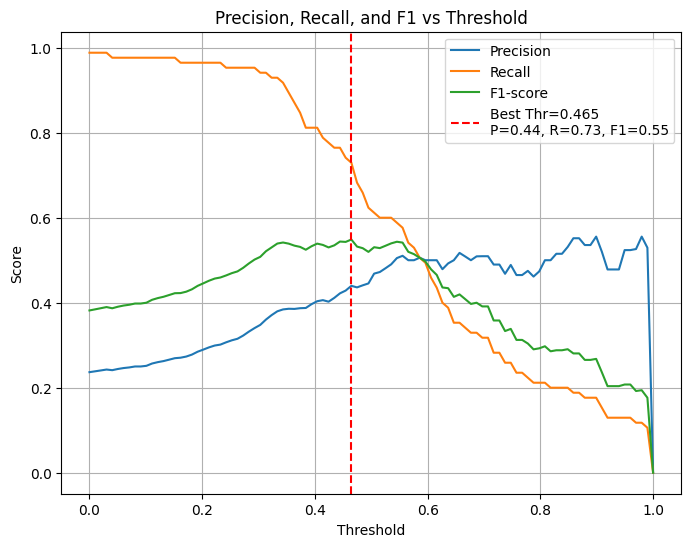

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

thresholds = np.linspace(all_values.min(), all_values.max(), 100)
best_thr, best_f1 = None, -1
best_precision, best_recall = None, None

precisions, recalls, f1s = [], [], []

for thr in thresholds:
    preds = all_values > thr
    tp = ((preds == 1) & (anomaly_mask == 1)).sum()
    fp = ((preds == 1) & (anomaly_mask == 0)).sum()
    fn = ((preds == 0) & (anomaly_mask == 1)).sum()
    
    precision = tp / (tp + fp + 1e-9)
    recall = tp / (tp + fn + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr
        best_precision = precision
        best_recall = recall

print(f"Best threshold: {best_thr:.3f}, F1 = {best_f1:.3f}, "
      f"Precision = {best_precision:.3f}, Recall = {best_recall:.3f}")

# Plot metrics
plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls, label="Recall")
plt.plot(thresholds, f1s, label="F1-score")

# Vertical line at best threshold
plt.axvline(best_thr, color="red", linestyle="--", 
            label=(f"Best Thr={best_thr:.3f}\n"
                   f"P={best_precision:.2f}, R={best_recall:.2f}, F1={best_f1:.2f}"))

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision, Recall, and F1 vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


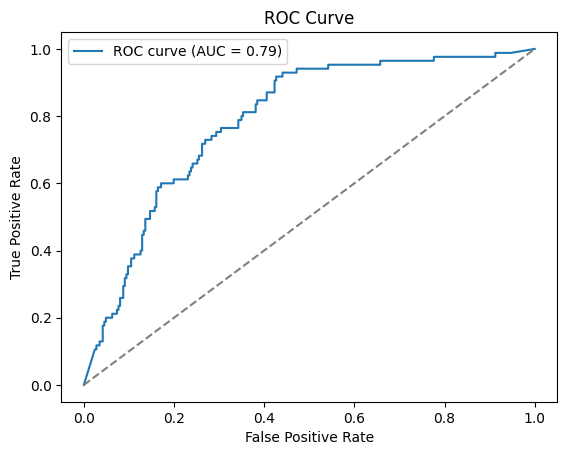

In [19]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(anomaly_mask, all_values)
roc_auc = auc(fpr, tpr)

np.savez("roc_all.npz", fpr=fpr, tpr=tpr, roc_auc=roc_auc)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # random line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()